# Section 1: Data sources

Harry Potter Network

https://www.stats.ox.ac.uk/~snijders/siena/HarryPotterData.html

Czech School Network
https://data.mendeley.com/datasets/9c3dth6cwp/2

Text
https://nuochenpku.github.io/HPD.github.io/index.html

# Section 2: Network construction and structural measures


## 2.1 Build Harry Potter support networks

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import difflib
import re

In [ ]:
adj_matrix = np.loadtxt("hpbook3.txt")
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
mapping = {i: i+1 for i in G.nodes}
HP = nx.relabel_nodes(G, mapping)

node_name_file = "hpnames.txt"

with open(node_name_file, "r", encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

header = [h.strip('"') for h in lines[0].split()]

for line in lines[1:]:
    parts = line.split("\t") if "\t" in line else line.split()

    raw_id = int(parts[0])
    node_id = raw_id

    name = parts[1].strip('"')

    HP.nodes[node_id]["name"] = name

    node_attribute_file = "hpattributes.txt"

with open(node_attribute_file, "r", encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

header = [h.strip('"') for h in lines[0].split()]

for line in lines[1:]:
    parts = line.split()
    node_id = parts[0]

    attrs = {header[i]: parts[i] for i in range(1, len(header))}

    HP.nodes[int(node_id)].update(attrs)

In [ ]:
# load HP2 / HP3 dialogue from "Character;Sentence" text

from pathlib import Path
import pandas as pd

hp2_csv_path = Path("Harry Potter 2.csv")
hp3_csv_path = Path("Harry Potter 3.csv")

def load_character_sentence_file(path: Path) -> pd.DataFrame:
    """
    Parse a file where each line looks like:
        Character;Sentence
    and everything after the first ';' is treated as the sentence,
    even if there are more ';' or TABs in the text.
    """
    rows = []
    with open(path, "r", encoding="utf-8-sig") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            # skip header
            if line.lower().startswith("character;"):
                continue
            if ";" not in line:
                continue
            speaker, sentence = line.split(";", 1)  # split only on the first ';'
            speaker = speaker.strip()
            sentence = sentence.strip()
            if speaker == "" or sentence == "":
                continue
            rows.append({"character": speaker, "line": sentence})
    return pd.DataFrame(rows)

df_hp2_lines = load_character_sentence_file(hp2_csv_path)
df_hp3_lines = load_character_sentence_file(hp3_csv_path)

print("HP2 lines shape:", df_hp2_lines.shape)
print("HP3 lines shape:", df_hp3_lines.shape)
df_hp2_lines.head()



HP2 lines shape: (1700, 2)
HP3 lines shape: (1638, 2)


,character,line
0,HARRY,"I can’t let you out, Hedwig."
1,HARRY,I’m not allowed to use magic outside of school.
2,HARRY,"Besides, if Uncle Vernon…"
3,VERNON,Harry Potter!
4,HARRY,Now you’ve done it.


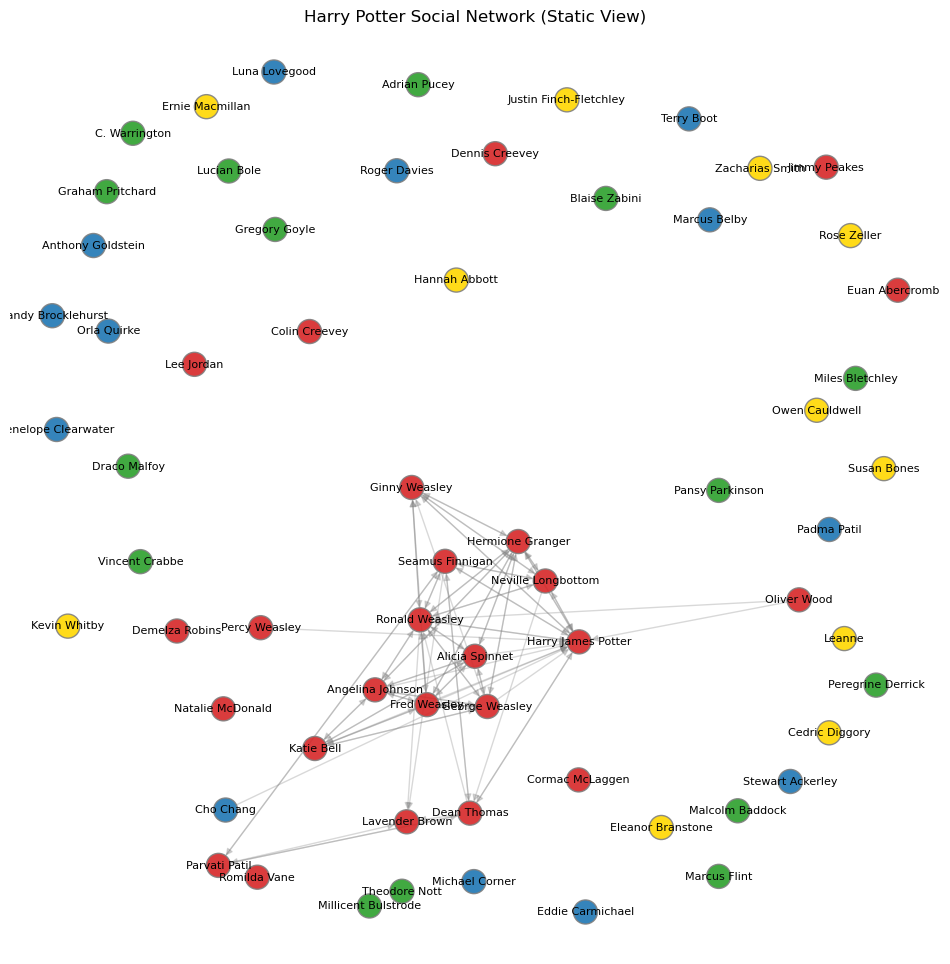

In [ ]:
plt.figure(figsize=(12, 12))
color_map_scheme = {
    '1': 'tab:red',    # Gryffindor
    '2': 'gold',       # Hufflepuff
    '3': 'tab:blue',   # Ravenclaw
    '4': 'tab:green'   # Slytherin
}


node_colors = []
for node in HP.nodes():
    house_id = HP.nodes[node].get('house')

    color = color_map_scheme.get(house_id, 'lightgrey')
    node_colors.append(color)


pos = nx.spring_layout(HP, k=0.3, iterations=10, seed=42)


nx.draw_networkx_nodes(HP, pos, node_color=node_colors, edgecolors='grey', alpha=0.9)

nx.draw_networkx_edges(HP, pos, alpha=0.3, edge_color='grey')

labels_dict = nx.get_node_attributes(HP, 'name')
nx.draw_networkx_labels(HP, pos, labels=labels_dict, font_size=8, font_family='sans-serif')


plt.title("Harry Potter Social Network (Static View)")
plt.axis('off')
plt.show()

## 2.2 Build Czech classroom networks

In [ ]:
file_path = 'F:/DTU/02805 Social Graphs/projectB/Czech school students/relational data.xlsx'
attributes_path = "F:/DTU/02805 Social Graphs/projectB/Czech school students/student attributes.xlsx"

sheet_names = ['01start', '01end']

attributes = pd.read_excel(attributes_path, header=1)

fields = [
    'gender',
    'HISEI',
    'whole_classroom_talk_end',
    'literacy_end',
    'need_of_success',
    'avoidance_of_failure'
]

graphs = {}

for sheet in sheet_names:
    print(f"Processing sheet: {sheet}")

    df = pd.read_excel(file_path, sheet_name=sheet, index_col=0)
    df.columns = df.columns.astype(int)
    df.index = df.index.astype(int)

    G = nx.DiGraph()
    G.add_nodes_from(df.index)

    for src in df.index:
        for dst in df.columns:
            if df.loc[src, dst] == 1:
                G.add_edge(src, dst)

    for node in G.nodes:
        matched = attributes[attributes['studentID'] == node]

        if len(matched) == 1:
            row = matched.iloc[0]
            for col in fields:
                G.nodes[node][col] = row[col]

    graphs[sheet] = G

    print(f"  - Nodes: {G.number_of_nodes()}")
    print(f"  - Edges: {G.number_of_edges()}")
    print()

G_cz_start = graphs['01start']
G_cz_end = graphs['01end']

Processing sheet: 01start
  - Nodes: 24
  - Edges: 208

Processing sheet: 01end
  - Nodes: 24
  - Edges: 237



In [ ]:
# Structural change between t1 and t2 (HP vs Czech)
def structural_change(G_start, G_end, label):
    s1 = graph_summary(G_start, label + "_start", directed=True).iloc[0]
    s2 = graph_summary(G_end,   label + "_end",   directed=True).iloc[0]
    return pd.DataFrame([{
        "pair": label,
        "delta_density":         s2["density"]      - s1["density"],
        "delta_reciprocity":     s2["reciprocity"]  - s1["reciprocity"],
        "delta_transitivity":    s2["transitivity"] - s1["transitivity"],
        "delta_avg_clustering":  s2["avg_clustering"] - s1["avg_clustering"],
    }])

df_struct_change = pd.concat(
    [
        structural_change(HP2, HP3, "HP"),
        structural_change(G_cz_start, G_cz_end, "Czech_01"),
    ],
    ignore_index=True,
)
df_struct_change


,pair,delta_density,delta_reciprocity,delta_transitivity,delta_avg_clustering
0,HP,-0.000992,0.013389,-0.003924,-0.015299
1,Czech_01,0.052536,0.094856,0.050265,0.065993


## 2.3 Global graph summaries and degree distributions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import json
import networkx as nx
from networkx.readwrite import json_graph

# Global seaborn style
sns.set_theme(style="white", context="talk")

In [ ]:
# Cell 2: Load Harry Potter networks (HP2, HP3)
with open("HP2.json", "r", encoding="utf-8") as f:
    hp2_data = json.load(f)
with open("HP3.json", "r", encoding="utf-8") as f:
    hp3_data = json.load(f)

HP2 = json_graph.node_link_graph(
    hp2_data,
    directed=hp2_data.get("directed", False),
    multigraph=hp2_data.get("multigraph", False),
    edges="links",
)

HP3 = json_graph.node_link_graph(
    hp3_data,
    directed=hp3_data.get("directed", False),
    multigraph=hp3_data.get("multigraph", False),
    edges="links",
)

print("HP2:", HP2.number_of_nodes(), "nodes,", HP2.number_of_edges(), "edges")
print("HP3:", HP3.number_of_nodes(), "nodes,", HP3.number_of_edges(), "edges")


HP2: 64 nodes, 91 edges
HP3: 64 nodes, 87 edges


In [ ]:
# Quick basic stats function for any directed graph
def basic_stats(G, name="G"):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)
    avg_out_degree = m / n if n > 0 else np.nan

    print(f"=== {name} ===")
    print(f"Nodes: {n}")
    print(f"Edges: {m}")
    print(f"Density: {density:.4f}")
    print(f"Average out-degree: {avg_out_degree:.2f}")

    if isinstance(G, nx.DiGraph):
        rec = nx.reciprocity(G)
        print(f"Reciprocity: {rec:.4f}")

    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    print(f"Largest weakly connected component size: {len(largest_wcc)}")
    print()

basic_stats(HP2, "HP2")
basic_stats(HP3, "HP3")


=== HP2 ===
Nodes: 64
Edges: 91
Density: 0.0226
Average out-degree: 1.42
Reciprocity: 0.7912
Largest weakly connected component size: 18

=== HP3 ===
Nodes: 64
Edges: 87
Density: 0.0216
Average out-degree: 1.36
Reciprocity: 0.8046
Largest weakly connected component size: 17



HP3 core network: 17 nodes, 87 edges


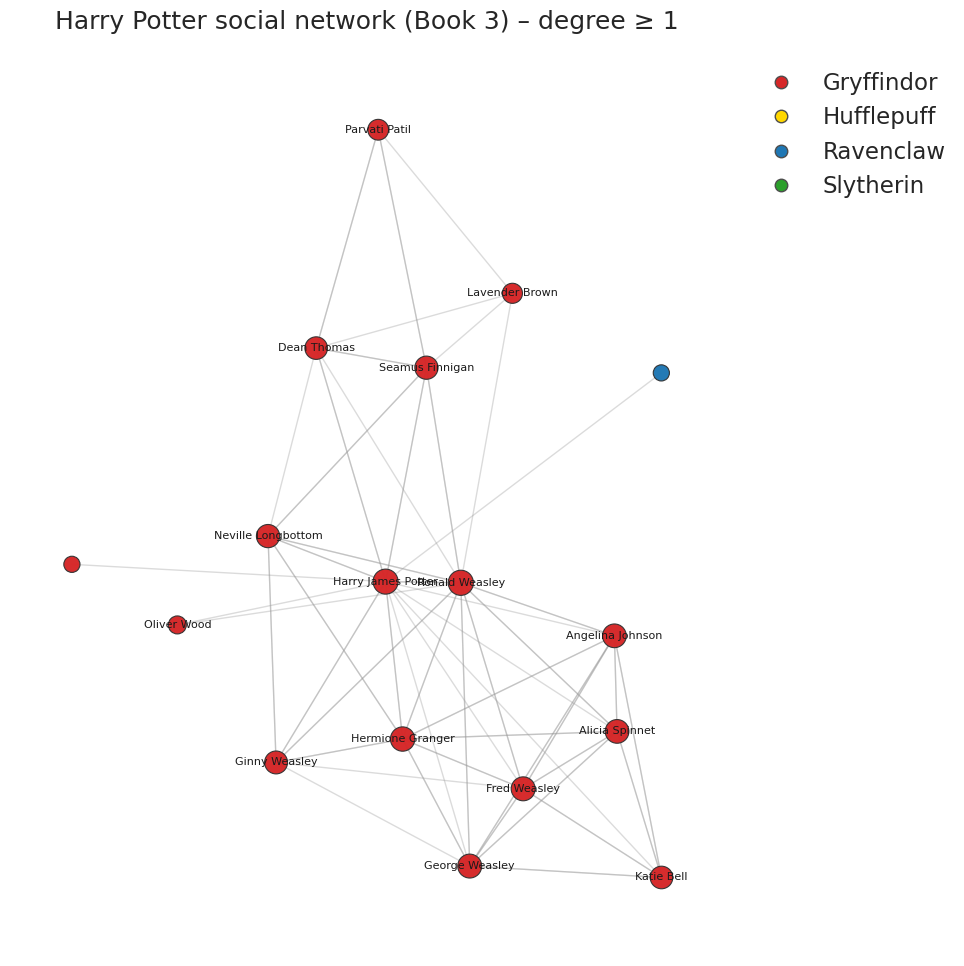

In [ ]:
# Visualize HP3 core network (degree >= 1)
deg_all_hp3 = dict(HP3.degree())
core_nodes_hp3 = [v for v, d in deg_all_hp3.items() if d >= 1]

HP3_core = HP3.subgraph(core_nodes_hp3).copy()
print(f"HP3 core network: {HP3_core.number_of_nodes()} nodes, {HP3_core.number_of_edges()} edges")

plt.figure(figsize=(10, 10))

# House color map
color_map_scheme = {
    "1": "tab:red",   # Gryffindor
    "2": "gold",      # Hufflepuff
    "3": "tab:blue",  # Ravenclaw
    "4": "tab:green", # Slytherin
}

houses_core = nx.get_node_attributes(HP3_core, "house")
deg_core = dict(HP3_core.degree())

scale_core = 80
node_colors_core = [
    color_map_scheme.get(houses_core.get(v), "lightgrey")
    for v in HP3_core.nodes()
]
node_sizes_core = [
    80 + scale_core * np.log1p(deg_core[v])
    for v in HP3_core.nodes()
]

pos_core = nx.kamada_kawai_layout(HP3_core)

nx.draw_networkx_edges(
    HP3_core, pos_core,
    alpha=0.35,
    width=1.0,
    edge_color="0.6",
    arrows=False,
)

nx.draw_networkx_nodes(
    HP3_core, pos_core,
    node_color=node_colors_core,
    node_size=node_sizes_core,
    linewidths=0.8,
    edgecolors="0.2",
    alpha=0.98,
)

labels_core = {
    v: HP3_core.nodes[v].get("name", str(v))
    for v, d in deg_core.items() if d >= 2
}
nx.draw_networkx_labels(
    HP3_core, pos_core,
    labels=labels_core,
    font_size=8,
)

legend_elements = [
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="tab:red", markeredgecolor="0.3",
           label="Gryffindor"),
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="gold", markeredgecolor="0.3",
           label="Hufflepuff"),
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="tab:blue", markeredgecolor="0.3",
           label="Ravenclaw"),
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="tab:green", markeredgecolor="0.3",
           label="Slytherin"),
]

plt.legend(
    handles=legend_elements,
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
)

plt.title("Harry Potter social network (Book 3) – degree ≥ 1", pad=16)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Global structural statistics and change over time
def graph_summary(G, name, directed=True):
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if directed and isinstance(G, nx.DiGraph):
        density = nx.density(G)
        reciprocity = nx.reciprocity(G)
        G_und = G.to_undirected()
    else:
        density = nx.density(G)
        reciprocity = np.nan
        G_und = G

    transitivity = nx.transitivity(G_und)
    avg_clustering = nx.average_clustering(G_und)

    if nx.is_connected(G_und):
        avg_path_len = nx.average_shortest_path_length(G_und)
    else:
        gcc_nodes = max(nx.connected_components(G_und), key=len)
        avg_path_len = nx.average_shortest_path_length(G_und.subgraph(gcc_nodes))

    return pd.DataFrame([{
        "name": name,
        "n_nodes": n,
        "n_edges": m,
        "density": density,
        "reciprocity": reciprocity,
        "transitivity": transitivity,
        "avg_clustering": avg_clustering,
        "avg_path_len_gcc": avg_path_len,
    }])

df_stats = pd.concat(
    [
        graph_summary(HP2, "HP2", directed=True),
        graph_summary(HP3, "HP3", directed=True),
        graph_summary(G_cz_start, "Czech_01start", directed=True),
        graph_summary(G_cz_end,   "Czech_01end",   directed=True),
    ],
    ignore_index=True,
)
df_stats

,name,n_nodes,n_edges,density,reciprocity,transitivity,avg_clustering,avg_path_len_gcc
0,HP2,64,91,0.022569,0.791209,0.640288,0.199845,1.647059
1,HP3,64,87,0.021577,0.804598,0.636364,0.184546,1.713235
2,Czech_01start,24,208,0.376812,0.673077,0.661432,0.725801,1.503623
3,Czech_01end,24,237,0.429348,0.767932,0.711697,0.791795,1.478261


In [ ]:
# Node-level measures for all four networks
def node_level_measures(G, name, directed=True):
    if directed and isinstance(G, nx.DiGraph):
        indeg = dict(G.in_degree())
        outdeg = dict(G.out_degree())
        deg = dict(G.degree())
        G_und = G.to_undirected()
    else:
        deg = dict(G.degree())
        indeg = {v: np.nan for v in G.nodes()}
        outdeg = {v: np.nan for v in G.nodes()}
        G_und = G

    # Use the largest connected component for betweenness and eigenvector
    gcc_nodes = max(nx.connected_components(G_und), key=len)
    G_gcc = G_und.subgraph(gcc_nodes)

    betw = nx.betweenness_centrality(G_gcc, normalized=True)
    eig = nx.eigenvector_centrality_numpy(G_gcc)

    rows = []
    for v in G.nodes():
        attrs = G.nodes[v]
        row = {
            "graph": name,
            "node": v,
            "name": attrs.get("name", v),
            "degree": deg[v],
            "indegree": indeg[v],
            "outdegree": outdeg[v],
            "betweenness": betw.get(v, 0.0),
            "eigenvector": eig.get(v, 0.0),
            "house": attrs.get("house", None),
            "gender": attrs.get("gender", None),
            "schoolyear": attrs.get("schoolyear", None),
        }
        # Czech-specific attributes if present
        for extra in [
            "HISEI",
            "whole_classroom_talk_end",
            "literacy_end",
            "need_of_success",
            "avoidance_of_failure",
        ]:
            if extra in attrs:
                row[extra] = attrs[extra]
        rows.append(row)
    return pd.DataFrame(rows)

df_nodes_hp2 = node_level_measures(HP2, "HP2", directed=True)
df_nodes_hp3 = node_level_measures(HP3, "HP3", directed=True)
df_nodes_cz_start = node_level_measures(G_cz_start, "Czech_01start", directed=True)
df_nodes_cz_end   = node_level_measures(G_cz_end,   "Czech_01end",   directed=True)

df_nodes_all = pd.concat(
    [df_nodes_hp2, df_nodes_hp3, df_nodes_cz_start, df_nodes_cz_end],
    ignore_index=True,
)
df_nodes_all.head()


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,house,gender,schoolyear,HISEI,whole_classroom_talk_end,literacy_end,need_of_success,avoidance_of_failure
0,HP2,1,Adrian Pucey,0,0,0,0.000000,0.000000,4,1,1989,NaN,NaN,NaN,NaN,NaN
1,HP2,2,Alicia Spinnet,15,7,8,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN
2,HP2,3,Angelina Johnson,13,7,6,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN
3,HP2,4,Anthony Goldstein,0,0,0,0.000000,0.000000,3,1,1991,NaN,NaN,NaN,NaN,NaN
4,HP2,5,Blaise Zabini,0,0,0,0.000000,0.000000,4,1,1991,NaN,NaN,NaN,NaN,NaN


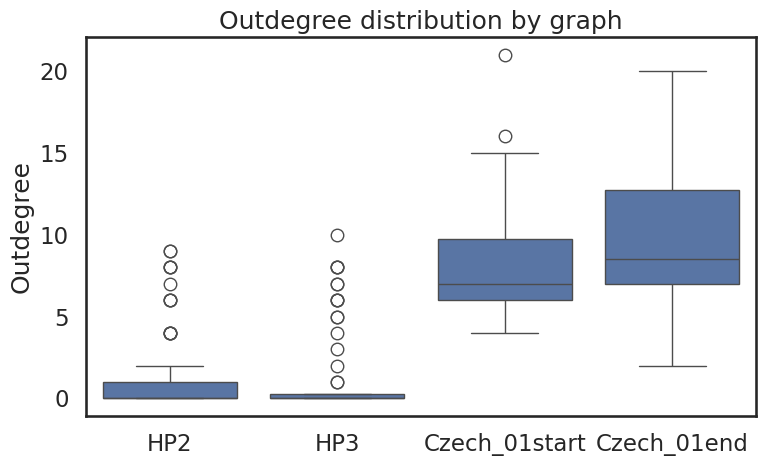

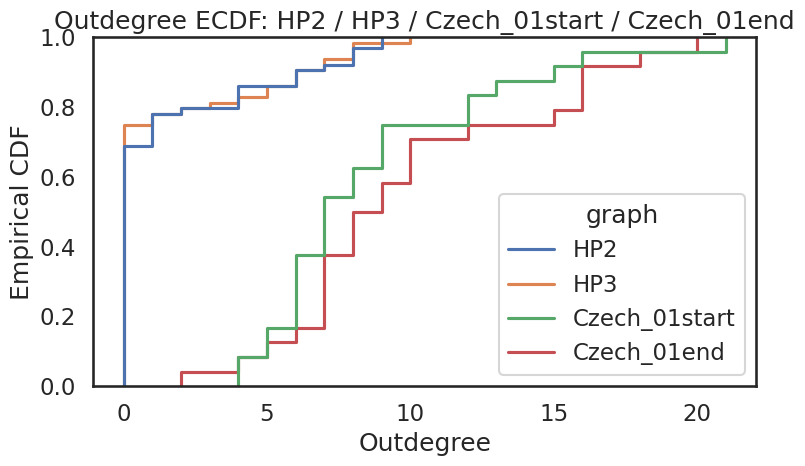

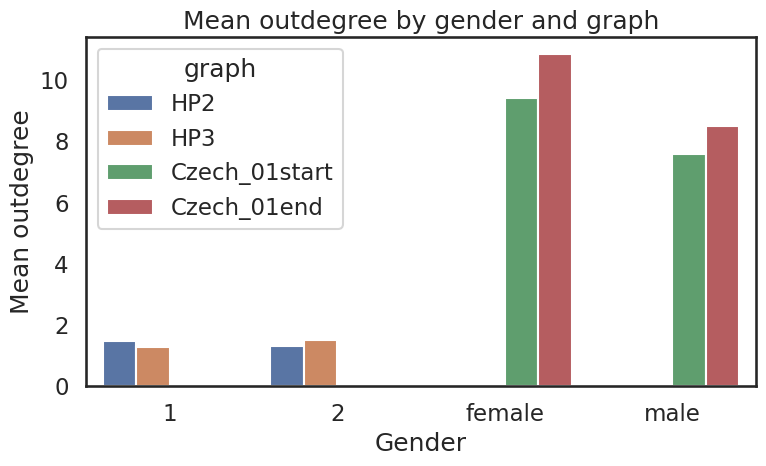

In [ ]:
# Outdegree distributions and gender differences
# a. Outdegree distribution by graph (boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_nodes_all,
    x="graph",
    y="outdegree",
)
plt.xlabel("")
plt.ylabel("Outdegree")
plt.title("Outdegree distribution by graph")
plt.tight_layout()
plt.show()

# b. Outdegree ECDF by graph
plt.figure(figsize=(8, 5))
sns.ecdfplot(
    data=df_nodes_all,
    x="outdegree",
    hue="graph",
)
plt.xlabel("Outdegree")
plt.ylabel("Empirical CDF")
plt.title("Outdegree ECDF: HP2 / HP3 / Czech_01start / Czech_01end")
plt.tight_layout()
plt.show()

# c. Mean outdegree by gender and graph
def mean_outdeg_by_gender(df_nodes, graph_name):
    sub = df_nodes[df_nodes["graph"] == graph_name]
    return (
        sub.groupby("gender")["outdegree"]
        .agg(["count", "mean", "std"])
        .reset_index()
        .assign(graph=graph_name)
    )

df_gender_hp2 = mean_outdeg_by_gender(df_nodes_all, "HP2")
df_gender_hp3 = mean_outdeg_by_gender(df_nodes_all, "HP3")
df_gender_cz_start = mean_outdeg_by_gender(df_nodes_all, "Czech_01start")
df_gender_cz_end   = mean_outdeg_by_gender(df_nodes_all, "Czech_01end")

df_gender = pd.concat(
    [df_gender_hp2, df_gender_hp3, df_gender_cz_start, df_gender_cz_end],
    ignore_index=True,
)

df_gender_plot = df_gender.dropna(subset=["gender"]).copy()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_gender_plot,
    x="gender",
    y="mean",
    hue="graph",
)
plt.ylabel("Mean outdegree")
plt.xlabel("Gender")
plt.title("Mean outdegree by gender and graph")
plt.tight_layout()
plt.show()


## 2.4 Homophily and mixing matrices

In [ ]:
# Assortativity (homophily) by attribute ===
def assortativity_by_attr(G, attr, directed=True):
    if directed and isinstance(G, nx.DiGraph):
        H = G.to_undirected()
    else:
        H = G
    nodes_with_attr = [v for v in H.nodes() if attr in H.nodes[v]]
    H = H.subgraph(nodes_with_attr).copy()
    if H.number_of_edges() == 0:
        return np.nan
    return nx.attribute_assortativity_coefficient(H, attr)

assort_hp2_house = assortativity_by_attr(HP2, "house", directed=True)
assort_hp3_house = assortativity_by_attr(HP3, "house", directed=True)
assort_hp2_gender = assortativity_by_attr(HP2, "gender", directed=True)
assort_hp3_gender = assortativity_by_attr(HP3, "gender", directed=True)
assort_hp2_year   = assortativity_by_attr(HP2, "schoolyear", directed=True)
assort_hp3_year   = assortativity_by_attr(HP3, "schoolyear", directed=True)

assort_cz_start_gender = assortativity_by_attr(G_cz_start, "gender", directed=True)
assort_cz_end_gender   = assortativity_by_attr(G_cz_end,   "gender", directed=True)

df_assort = pd.DataFrame(
    [
        {"graph": "HP2",          "attr": "house",      "assortativity": assort_hp2_house},
        {"graph": "HP3",          "attr": "house",      "assortativity": assort_hp3_house},
        {"graph": "HP2",          "attr": "gender",     "assortativity": assort_hp2_gender},
        {"graph": "HP3",          "attr": "gender",     "assortativity": assort_hp3_gender},
        {"graph": "HP2",          "attr": "schoolyear", "assortativity": assort_hp2_year},
        {"graph": "HP3",          "attr": "schoolyear", "assortativity": assort_hp3_year},
        {"graph": "Czech_01start","attr": "gender",     "assortativity": assort_cz_start_gender},
        {"graph": "Czech_01end",  "attr": "gender",     "assortativity": assort_cz_end_gender},
    ]
)
df_assort


,graph,attr,assortativity
0,HP2,house,0.378531
1,HP3,house,-0.009709
2,HP2,gender,0.036190
3,HP3,gender,-0.087108
4,HP2,schoolyear,0.098822
5,HP3,schoolyear,0.116147
6,Czech_01start,gender,0.343693
7,Czech_01end,gender,0.341254


In [ ]:
# Mixing summary (observed vs expected homophily)
def mixing_summary(G, attr, directed=True):
    """
    Return mixing matrix, observed same-type edge fraction, expected same-type
    fraction under random mixing with same attribute distribution, and their ratio.
    """
    if directed and isinstance(G, nx.DiGraph):
        H = G.to_undirected()
    else:
        H = G

    keep = [v for v in H.nodes() if attr in H.nodes[v]]
    H = H.subgraph(keep).copy()
    if H.number_of_edges() == 0:
        return None

    mix = nx.attribute_mixing_matrix(H, attr, normalized=True)
    same_frac = np.trace(mix)

    values = [H.nodes[v][attr] for v in H.nodes()]
    vc = pd.Series(values).value_counts(normalize=True)
    expected_same_frac = (vc ** 2).sum()

    ratio = same_frac / expected_same_frac if expected_same_frac > 0 else np.nan
    return mix, same_frac, expected_same_frac, ratio

# HP: house / gender / schoolyear
mix_hp2_house = mixing_summary(HP2, "house", directed=True)
mix_hp3_house = mixing_summary(HP3, "house", directed=True)
mix_hp2_gender = mixing_summary(HP2, "gender", directed=True)
mix_hp3_gender = mixing_summary(HP3, "gender", directed=True)

# Czech: gender
mix_cz_start_gender = mixing_summary(G_cz_start, "gender", directed=True)
mix_cz_end_gender   = mixing_summary(G_cz_end,   "gender", directed=True)

def summarize_mixing(label, attr, result):
    if result is None:
        return None
    mix, same_frac, exp_same, ratio = result
    return {
        "graph": label,
        "attr": attr,
        "same_fraction": same_frac,
        "expected_same_fraction": exp_same,
        "ratio_obs_over_expected": ratio,
    }

rows = []
rows.append(summarize_mixing("HP2", "house", mix_hp2_house))
rows.append(summarize_mixing("HP3", "house", mix_hp3_house))
rows.append(summarize_mixing("HP2", "gender", mix_hp2_gender))
rows.append(summarize_mixing("HP3", "gender", mix_hp3_gender))
rows.append(summarize_mixing("Czech_01start", "gender", mix_cz_start_gender))
rows.append(summarize_mixing("Czech_01end",   "gender", mix_cz_end_gender))

df_mixing_summary = pd.DataFrame([r for r in rows if r is not None])
df_mixing_summary


,graph,attr,same_fraction,expected_same_fraction,ratio_obs_over_expected
0,HP2,house,0.945455,0.278320,3.397002
1,HP3,house,0.980769,0.278320,3.523887
2,HP2,gender,0.581818,0.539551,1.078338
3,HP3,gender,0.480769,0.539551,0.891055
4,Czech_01start,gender,0.688406,0.513889,1.339600
5,Czech_01end,gender,0.691781,0.513889,1.346168


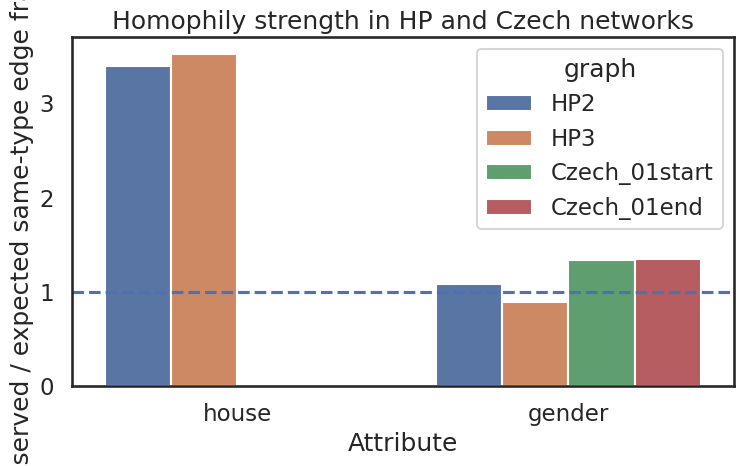

In [ ]:
# Plot homophily strength (observed / expected)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_mixing_summary,
    x="attr",
    y="ratio_obs_over_expected",
    hue="graph",
)
plt.axhline(1.0, linestyle="--")
plt.ylabel("Observed / expected same-type edge fraction")
plt.xlabel("Attribute")
plt.title("Homophily strength in HP and Czech networks")
plt.tight_layout()
plt.show()


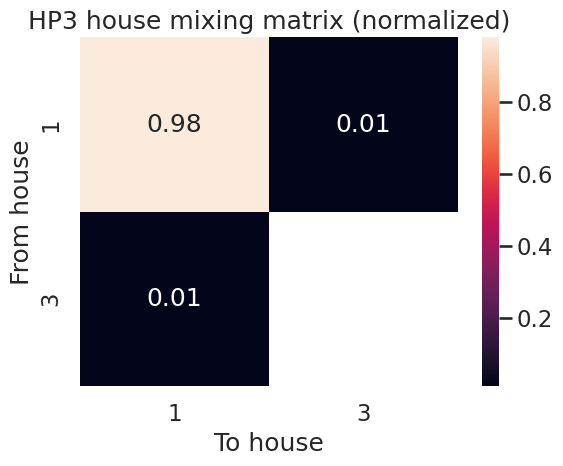

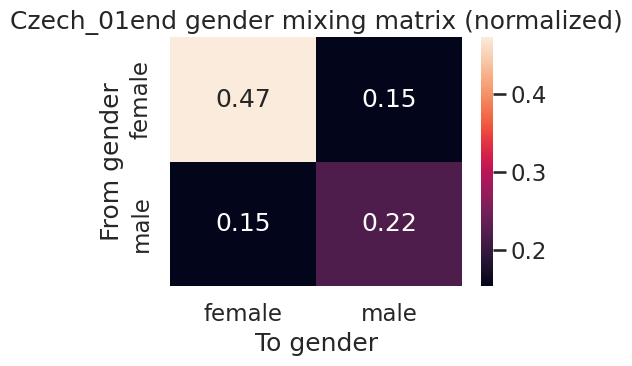

In [ ]:
# Mixing matrix heatmaps (HP3 house, Czech_01end gender) ===
# HP3: house mixing
H_hp3 = HP3.to_undirected()
keep_hp3 = [v for v in H_hp3.nodes() if "house" in H_hp3.nodes[v]]
H_hp3 = H_hp3.subgraph(keep_hp3).copy()

mix_dict_hp3 = nx.attribute_mixing_dict(H_hp3, "house", normalized=True)
labels_house = sorted(mix_dict_hp3.keys())
mix_mat_hp3 = pd.DataFrame(mix_dict_hp3).reindex(
    index=labels_house, columns=labels_house
)

plt.figure(figsize=(6, 5))
sns.heatmap(
    mix_mat_hp3,
    annot=True,
    fmt=".2f",
)
plt.xlabel("To house")
plt.ylabel("From house")
plt.title("HP3 house mixing matrix (normalized)")
plt.tight_layout()
plt.show()

# Czech_01end: gender mixing
H_cz = G_cz_end.to_undirected()
keep_cz = [v for v in H_cz.nodes() if "gender" in H_cz.nodes[v]]
H_cz = H_cz.subgraph(keep_cz).copy()

mix_dict_cz = nx.attribute_mixing_dict(H_cz, "gender", normalized=True)
labels_gender = sorted(mix_dict_cz.keys())
mix_mat_cz = pd.DataFrame(mix_dict_cz).reindex(
    index=labels_gender, columns=labels_gender
)

plt.figure(figsize=(5, 4))
sns.heatmap(
    mix_mat_cz,
    annot=True,
    fmt=".2f",
)
plt.xlabel("To gender")
plt.ylabel("From gender")
plt.title("Czech_01end gender mixing matrix (normalized)")
plt.tight_layout()
plt.show()


## 2.5 Structural holes and bridging centrality

In [ ]:
# Structural holes and bridging centrality
def add_structural_hole_measures(G, df_nodes, graph_name, directed=True):
    """
    For a given graph, compute:
      - k-core index
      - bridging coefficient
      - bridging centrality (bridging coefficient * betweenness)
    and add them to df_nodes for rows with graph == graph_name.
    """
    if directed and isinstance(G, nx.DiGraph):
        H = G.to_undirected()
    else:
        H = G

    core_num = nx.core_number(H)

    sub = df_nodes[df_nodes["graph"] == graph_name]
    if "betweenness" in sub.columns and sub["betweenness"].notna().any():
        betw_dict = dict(zip(sub["node"], sub["betweenness"]))
    else:
        betw_dict = nx.betweenness_centrality(H, normalized=True)

    deg = dict(H.degree())
    neighbors = {v: set(H.neighbors(v)) for v in H.nodes()}

    bridging_coeff = {}
    bridging_centrality = {}

    for v in H.nodes():
        k_v = deg.get(v, 0)
        if k_v == 0:
            bridging_coeff[v] = 0.0
            bridging_centrality[v] = 0.0
            continue
        neigh = neighbors[v]
        if not neigh:
            bridging_coeff[v] = 0.0
            bridging_centrality[v] = 0.0
            continue
        denom = sum(1.0 / deg.get(u, 1) for u in neigh)
        bc = (1.0 / k_v) / denom if denom > 0 else 0.0
        bridging_coeff[v] = bc
        bridging_centrality[v] = bc * betw_dict.get(v, 0.0)

    df_nodes2 = df_nodes.copy()
    mask = df_nodes2["graph"] == graph_name
    df_nodes2.loc[mask, "kcore"] = df_nodes2.loc[mask, "node"].map(core_num)
    df_nodes2.loc[mask, "bridging_coeff"] = df_nodes2.loc[mask, "node"].map(bridging_coeff)
    df_nodes2.loc[mask, "bridging_centrality"] = df_nodes2.loc[mask, "node"].map(bridging_centrality)

    return df_nodes2

df_nodes_all = add_structural_hole_measures(HP2,        df_nodes_all, "HP2",           directed=True)
df_nodes_all = add_structural_hole_measures(HP3,        df_nodes_all, "HP3",           directed=True)
df_nodes_all = add_structural_hole_measures(G_cz_start, df_nodes_all, "Czech_01start", directed=True)
df_nodes_all = add_structural_hole_measures(G_cz_end,   df_nodes_all, "Czech_01end",   directed=True)

df_nodes_all.head()


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,house,gender,schoolyear,HISEI,whole_classroom_talk_end,literacy_end,need_of_success,avoidance_of_failure,kcore,bridging_coeff,bridging_centrality
0,HP2,1,Adrian Pucey,0,0,0,0.000000,0.000000,4,1,1989,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000
1,HP2,2,Alicia Spinnet,15,7,8,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN,7.0,0.137715,0.000338
2,HP2,3,Angelina Johnson,13,7,6,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN,7.0,0.137715,0.000338
3,HP2,4,Anthony Goldstein,0,0,0,0.000000,0.000000,3,1,1991,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000
4,HP2,5,Blaise Zabini,0,0,0,0.000000,0.000000,4,1,1991,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000


In [ ]:
# Top bridging nodes (structural holes)
def top_bridgers(df_nodes, graph_name, k=10):
    sub = df_nodes[df_nodes["graph"] == graph_name].copy()
    return sub.sort_values("bridging_centrality", ascending=False)[
        [
            "name",
            "house",
            "gender",
            "schoolyear",
            "degree",
            "betweenness",
            "kcore",
            "bridging_coeff",
            "bridging_centrality",
        ]
    ].head(k)

print("HP2 top bridging nodes:")
display(top_bridgers(df_nodes_all, "HP2", k=10))

print("HP3 top bridging nodes:")
display(top_bridgers(df_nodes_all, "HP3", k=10))

print("Czech_01start top bridging students:")
display(top_bridgers(df_nodes_all, "Czech_01start", k=10))

print("Czech_01end top bridging students:")
display(top_bridgers(df_nodes_all, "Czech_01end", k=10))


HP2 top bridging nodes:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
24,Harry James Potter,1,1,1991,24,0.586397,7.0,0.010129,0.005940
55,Ronald Weasley,1,1,1991,17,0.104779,6.0,0.045697,0.004788
20,Ginny Weasley,1,2,1992,4,0.003676,2.0,0.513032,0.001886
19,George Weasley,1,1,1989,17,0.012868,7.0,0.094840,0.001220
18,Fred Weasley,1,1,1989,17,0.012868,7.0,0.094840,0.001220
1,Alicia Spinnet,1,2,1989,15,0.002451,7.0,0.137715,0.000338
25,Hermione Granger,1,2,1991,13,0.002451,7.0,0.137715,0.000338
2,Angelina Johnson,1,2,1989,13,0.002451,7.0,0.137715,0.000338
8,Colin Creevey,1,1,1992,0,0.000000,0.0,0.000000,0.000000
9,Cormac McLaggen,1,1,1990,0,0.000000,0.0,0.000000,0.000000


HP3 top bridging nodes:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
74,Dean Thomas,1,1,1991,9,0.059722,4.0,0.155556,0.009290
121,Seamus Finnigan,1,1,1991,11,0.059722,4.0,0.155556,0.009290
119,Ronald Weasley,1,1,1991,21,0.202540,6.0,0.038781,0.007855
88,Harry James Potter,1,1,1991,20,0.409444,6.0,0.017376,0.007115
94,Lavender Brown,1,2,1991,4,0.013492,3.0,0.333333,0.004497
107,Neville Longbottom,1,1,1991,11,0.015873,4.0,0.213740,0.003393
89,Hermione Granger,1,2,1991,16,0.013056,6.0,0.122093,0.001594
83,George Weasley,1,1,1989,14,0.010635,6.0,0.118243,0.001258
82,Fred Weasley,1,1,1989,14,0.010635,6.0,0.118243,0.001258
84,Ginny Weasley,1,2,1992,10,0.004167,5.0,0.239316,0.000997


Czech_01start top bridging students:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
141,114,None,female,None,30,0.195982,8.0,0.021781,0.004269
148,121,None,male,None,27,0.061566,8.0,0.045574,0.002806
147,120,None,female,None,26,0.067203,8.0,0.038947,0.002617
150,123,None,female,None,17,0.035832,8.0,0.059481,0.002131
131,104,None,female,None,10,0.006498,7.0,0.286689,0.001863
137,110,None,male,None,21,0.032971,8.0,0.054098,0.001784
128,101,None,male,None,19,0.014582,8.0,0.098609,0.001438
139,112,None,male,None,17,0.019575,8.0,0.069968,0.001370
134,107,None,female,None,20,0.022553,8.0,0.056757,0.001280
138,111,None,male,None,18,0.013660,8.0,0.084035,0.001148


Czech_01end top bridging students:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
174,123,None,female,None,28,0.148521,9.0,0.024322,0.003612
172,121,None,male,None,34,0.104100,9.0,0.032005,0.003332
161,110,None,male,None,27,0.061353,9.0,0.041137,0.002524
165,114,None,female,None,22,0.052903,9.0,0.046319,0.002450
152,101,None,male,None,20,0.024827,8.0,0.068421,0.001699
171,120,None,female,None,21,0.014879,9.0,0.079174,0.001178
153,102,None,female,None,14,0.005703,8.0,0.175964,0.001004
158,107,None,female,None,26,0.019005,9.0,0.048548,0.000923
160,109,None,female,None,30,0.019005,9.0,0.048548,0.000923
175,124,None,female,None,27,0.019005,9.0,0.048548,0.000923


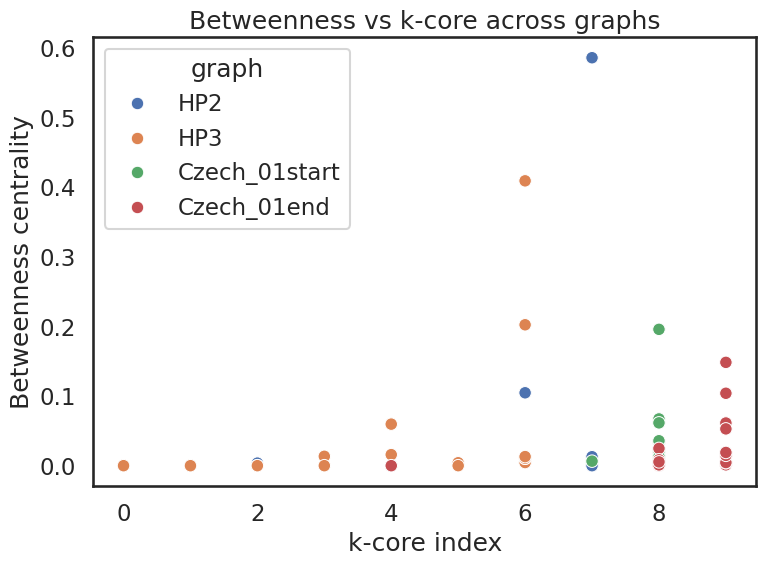

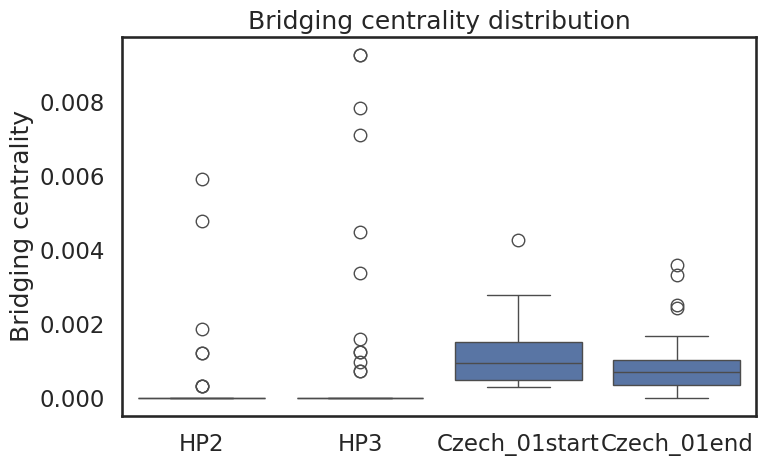

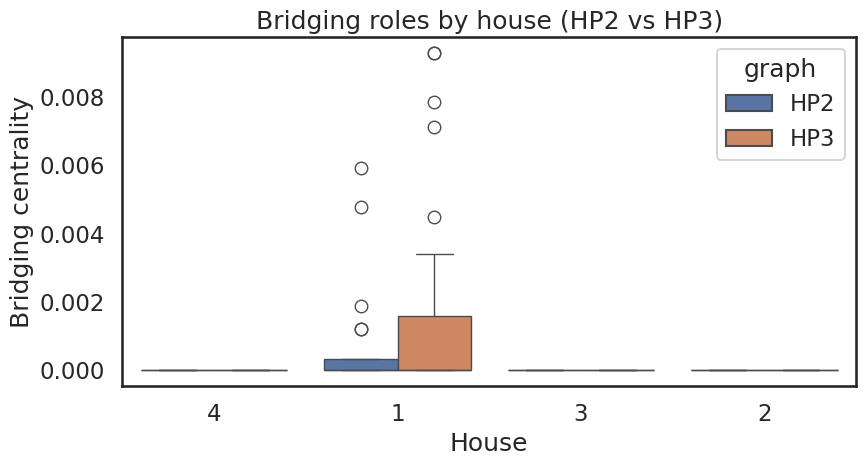

In [ ]:
# Plots for structural holes
# a. Betweenness vs k-core by graph
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_nodes_all,
    x="kcore",
    y="betweenness",
    hue="graph",
)
plt.ylabel("Betweenness centrality")
plt.xlabel("k-core index")
plt.title("Betweenness vs k-core across graphs")
plt.tight_layout()
plt.show()

# b. Bridging centrality distribution by graph
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_nodes_all,
    x="graph",
    y="bridging_centrality",
)
plt.ylabel("Bridging centrality")
plt.xlabel("")
plt.title("Bridging centrality distribution")
plt.tight_layout()
plt.show()

# c. Bridging centrality by house (HP only)
df_hp_bridge = df_nodes_all[
    df_nodes_all["graph"].isin(["HP2", "HP3"])
].dropna(subset=["house"])

plt.figure(figsize=(9, 5))
sns.boxplot(
    data=df_hp_bridge,
    x="house",
    y="bridging_centrality",
    hue="graph",
)
plt.ylabel("Bridging centrality")
plt.xlabel("House")
plt.title("Bridging roles by house (HP2 vs HP3)")
plt.tight_layout()
plt.show()


In [ ]:
# New edge diagnostics (reciprocity and triadic closure)
def edge_set(G):
    return set(G.edges())

def new_edge_diagnostics(G_start, G_end, label):
    """
    For edges that appear in G_end but not in G_start, compute:
      - fraction that are reciprocal with respect to G_start
      - fraction that close at least one triangle using G_start's undirected structure
    """
    E1 = edge_set(G_start)
    E2 = edge_set(G_end)
    new_edges = list(E2 - E1)
    if not new_edges:
        return pd.DataFrame([{
            "pair": label,
            "n_new_edges": 0,
            "frac_new_reciprocal": np.nan,
            "frac_new_closing_triangles": np.nan,
        }])

    G_und_start = G_start.to_undirected()
    neighbors_start = {v: set(G_und_start.neighbors(v)) for v in G_und_start.nodes()}

    reciprocal_flags = []
    triad_flags = []

    for i, j in new_edges:
        reciprocal_flags.append((j, i) in E1)

        neigh_i = neighbors_start.get(i, set())
        neigh_j = neighbors_start.get(j, set())
        closing = len(neigh_i & neigh_j) > 0
        triad_flags.append(closing)

    return pd.DataFrame([{
        "pair": label,
        "n_new_edges": len(new_edges),
        "frac_new_reciprocal": np.mean(reciprocal_flags),
        "frac_new_closing_triangles": np.mean(triad_flags),
    }])

diag_hp = new_edge_diagnostics(HP2, HP3, "HP2→HP3")
diag_cz = new_edge_diagnostics(G_cz_start, G_cz_end, "Czech 01start→01end")

df_new_edge_diag = pd.concat([diag_hp, diag_cz], ignore_index=True)
df_new_edge_diag


,pair,n_new_edges,frac_new_reciprocal,frac_new_closing_triangles
0,HP2→HP3,25,0.28,0.64
1,Czech 01start→01end,80,0.40,1.00


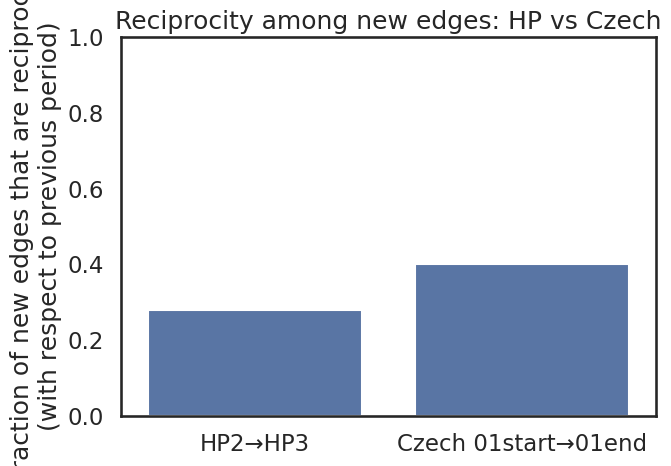

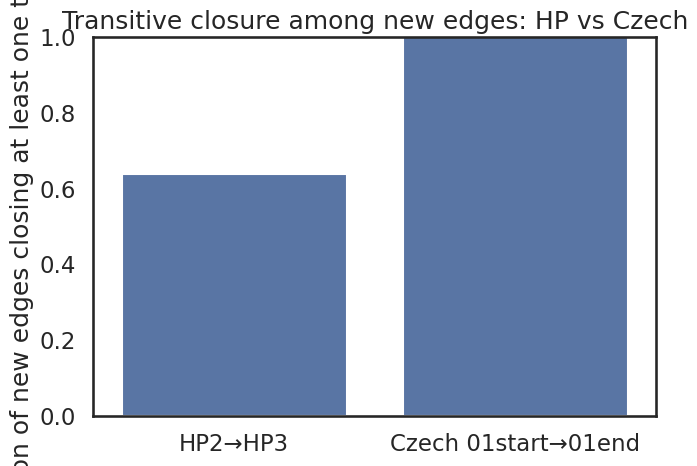

In [ ]:
# Plots for new-edge reciprocity and triadic closure
plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_new_edge_diag,
    x="pair",
    y="frac_new_reciprocal",
)
plt.ylabel("Fraction of new edges that are reciprocal\n(with respect to previous period)")
plt.xlabel("")
plt.title("Reciprocity among new edges: HP vs Czech")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_new_edge_diag,
    x="pair",
    y="frac_new_closing_triangles",
)
plt.ylabel("Fraction of new edges closing at least one triangle")
plt.xlabel("")
plt.title("Transitive closure among new edges: HP vs Czech")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
# Degree centralization
def degree_centralization(G, directed=True):
    """
    Freeman outdegree centralization, normalized by its maximum for a star graph.
    """
    if directed and isinstance(G, nx.DiGraph):
        deg = dict(G.out_degree())
    else:
        deg = dict(G.degree())
    n = len(deg)
    if n <= 2:
        return np.nan
    max_deg = max(deg.values())
    sum_diff = sum(max_deg - d for d in deg.values())
    max_c = (n - 1) * (n - 2)  # star graph
    return sum_diff / max_c if max_c > 0 else np.nan

df_centralization = pd.DataFrame([
    {"graph": "HP2",          "outdegree_centralization": degree_centralization(HP2, directed=True)},
    {"graph": "HP3",          "outdegree_centralization": degree_centralization(HP3, directed=True)},
    {"graph": "Czech_01start","outdegree_centralization": degree_centralization(G_cz_start, directed=True)},
    {"graph": "Czech_01end",  "outdegree_centralization": degree_centralization(G_cz_end, directed=True)},
])
df_centralization


,graph,outdegree_centralization
0,HP2,0.124168
1,HP3,0.141577
2,Czech_01start,0.584980
3,Czech_01end,0.480237


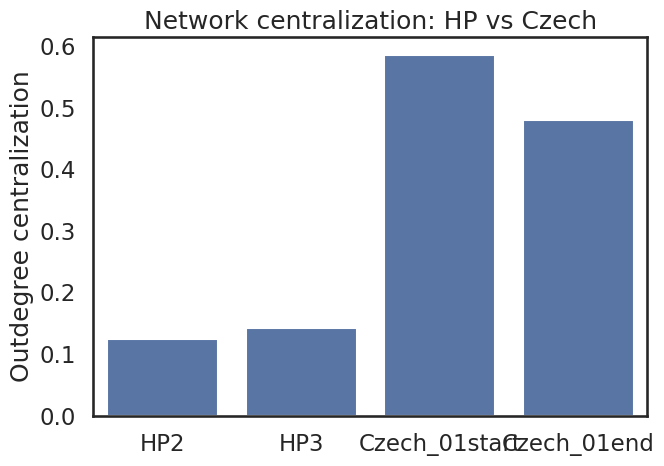

In [ ]:
# Plot network centralization
plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_centralization,
    x="graph",
    y="outdegree_centralization",
)
plt.ylabel("Outdegree centralization")
plt.xlabel("")
plt.title("Network centralization: HP vs Czech")
plt.tight_layout()
plt.show()


# Section 3: NLP and dialogue network

## 3.1 Build HPD co-occurrence network

In [ ]:
# load HP2 / HP3 dialogue from "Character;Sentence" text

from pathlib import Path
import pandas as pd

hp2_csv_path = Path("Harry Potter 2.csv")
hp3_csv_path = Path("Harry Potter 3.csv")

def load_character_sentence_file(path: Path) -> pd.DataFrame:
    """
    Parse a file where each line looks like:
        Character;Sentence
    and everything after the first ';' is treated as the sentence,
    even if there are more ';' or TABs in the text.
    """
    rows = []
    with open(path, "r", encoding="utf-8-sig") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            # skip header
            if line.lower().startswith("character;"):
                continue
            if ";" not in line:
                continue
            speaker, sentence = line.split(";", 1)  # split only on the first ';'
            speaker = speaker.strip()
            sentence = sentence.strip()
            if speaker == "" or sentence == "":
                continue
            rows.append({"character": speaker, "line": sentence})
    return pd.DataFrame(rows)

df_hp2_lines = load_character_sentence_file(hp2_csv_path)
df_hp3_lines = load_character_sentence_file(hp3_csv_path)

print("HP2 lines shape:", df_hp2_lines.shape)
print("HP3 lines shape:", df_hp3_lines.shape)
df_hp2_lines.head()



HP2 lines shape: (1700, 2)
HP3 lines shape: (1638, 2)


,character,line
0,HARRY,"I can’t let you out, Hedwig."
1,HARRY,I’m not allowed to use magic outside of school.
2,HARRY,"Besides, if Uncle Vernon…"
3,VERNON,Harry Potter!
4,HARRY,Now you’ve done it.


In [ ]:
# sentiment model and per-line polarity scores

# Install transformers once per runtime (comment out if already installed)
!pip install -q transformers accelerate torch

from transformers import pipeline

sent_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def sentiment_score(text: str) -> float:
    """
    Map a dialogue line to a scalar sentiment in [-1, 1].
    Positive label -> +score, negative label -> -score.
    """
    if not isinstance(text, str) or not text.strip():
        return 0.0
    # Truncate very long lines to avoid model limits; usually not needed for dialogue
    text_trunc = text[:512]
    result = sent_pipe(text_trunc)[0]
    label = result["label"].upper()
    score = float(result["score"])
    if label == "NEGATIVE":
        return -score
    else:
        return score

# Apply to every dialogue line
# If datasets are large, you can slice first to test (e.g., df_hp2_lines.head(200))
df_hp2_lines["sentiment"] = df_hp2_lines["line"].apply(sentiment_score)
df_hp3_lines["sentiment"] = df_hp3_lines["line"].apply(sentiment_score)

df_hp2_lines.head()


Device set to use cpu


,character,line,sentiment
0,HARRY,"I can’t let you out, Hedwig.",0.999220
1,HARRY,I’m not allowed to use magic outside of school.,-0.982936
2,HARRY,"Besides, if Uncle Vernon…",0.829819
3,VERNON,Harry Potter!,0.999273
4,HARRY,Now you’ve done it.,0.999117


In [ ]:
# aggregate lexical features per character in HP2 / HP3

def tokenize_simple(text: str):
    """
    Very simple English tokenizer: lowercase, alphabetic tokens and apostrophes.
    """
    return re.findall(r"[A-Za-z']+", text.lower())

def aggregate_character_features(df_lines, book_label: str):
    """
    df_lines: DataFrame with columns 'character', 'line', 'sentiment'.
    book_label: e.g. "HP2" or "HP3" for tracking.
    Returns a DataFrame with one row per character and text-based features.
    """
    rows = []
    for character, sub in df_lines.groupby("character"):
        texts = sub["line"].tolist()
        sentiments = sub["sentiment"].tolist()
        joined = " ".join(texts)
        tokens = tokenize_simple(joined)
        n_tokens = len(tokens)
        vocab = set(tokens)
        vocab_size = len(vocab)
        ttr = vocab_size / n_tokens if n_tokens > 0 else 0.0
        avg_sent = float(np.mean(sentiments)) if len(sentiments) > 0 else 0.0

        rows.append({
            "book": book_label,
            "character": character,
            "n_lines": len(texts),
            "n_tokens": n_tokens,
            "vocab_size": vocab_size,
            "type_token_ratio": ttr,
            "mean_line_sentiment": avg_sent,
        })
    return pd.DataFrame(rows)

df_nlp_hp2 = aggregate_character_features(df_hp2_lines, "HP2")
df_nlp_hp3 = aggregate_character_features(df_hp3_lines, "HP3")

print(df_nlp_hp2.head())
print(df_nlp_hp3.head())


  book              character  n_lines  n_tokens  vocab_size  \
0  HP2                 ARAGOG       20       131          84   
1  HP2           AUNT PETUNIA        3        20          19   
2  HP2  AUNT PETUNIA & DUDLEY        1         1           1   
3  HP2                    BOY        1         3           3   
4  HP2                  CLASS        1         3           3   

   type_token_ratio  mean_line_sentiment  
0          0.641221            -0.170967  
1          0.950000             0.340444  
2          1.000000             0.989967  
3          1.000000             0.991758  
4          1.000000             0.999840  
  book     character  n_lines  n_tokens  vocab_size  type_token_ratio  \
0  HP3    AUNT MARGE       37       249         135          0.542169   
1  HP3  AUNT PETUNIA        6        20          17          0.850000   
2  HP3           BEM        8        53          42          0.792453   
3  HP3           BOY        2         6           6          1.00

In [ ]:
# normalize names and build mapping from dialogue names to network names ===

import re

def norm_name(s: str) -> str:
    """
    Normalize a name:
      - uppercase
      - keep only A–Z and spaces
      - collapse multiple spaces
    Example: "Aunt  Petunia  " -> "AUNT PETUNIA"
    """
    if not isinstance(s, str):
        return ""
    s = s.upper()
    s = re.sub(r"[^A-Z ]+", " ", s)     # keep letters and spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Canonical (network) names
df_nodes_hp2["name_norm"] = df_nodes_hp2["name"].apply(norm_name)
df_nodes_hp3["name_norm"] = df_nodes_hp3["name"].apply(norm_name)

net_names_hp2 = df_nodes_hp2["name_norm"].unique().tolist()
net_names_hp3 = df_nodes_hp3["name_norm"].unique().tolist()

print("Example network names (normalized, HP2):", net_names_hp2[:10])
# === Cell 7b: guess mapping from dialogue names to network names ===

def guess_network_name(short_name_norm: str, net_names: list[str]) -> str | None:
    """
    Given a normalized dialogue name (e.g. 'HARRY'),
    try to find a unique normalized network name that contains it
    (e.g. 'HARRY POTTER').
    If multiple or none match, return None.
    """
    if not short_name_norm:
        return None
    candidates = [
        full for full in net_names
        if short_name_norm == full
        or short_name_norm + " " in full
        or " " + short_name_norm in full
        or short_name_norm in full  # fallback
    ]
    # Remove obvious multi-match junk like 'AUNT PETUNIA DUDLEY'
    candidates = list(set(candidates))
    if len(candidates) == 1:
        return candidates[0]
    else:
        return None

# Add normalized dialogue names
df_nlp_hp2["char_norm"] = df_nlp_hp2["character"].apply(norm_name)
df_nlp_hp3["char_norm"] = df_nlp_hp3["character"].apply(norm_name)

# Guess mapping for each dialogue-side character
df_nlp_hp2["net_name_norm"] = df_nlp_hp2["char_norm"].apply(
    lambda x: guess_network_name(x, net_names_hp2)
)
df_nlp_hp3["net_name_norm"] = df_nlp_hp3["char_norm"].apply(
    lambda x: guess_network_name(x, net_names_hp3)
)

print("HP2: characters with a guessed match in the network:")
display(df_nlp_hp2[df_nlp_hp2["net_name_norm"].notna()].head(10))

print("HP3: characters with a guessed match in the network:")
display(df_nlp_hp3[df_nlp_hp3["net_name_norm"].notna()].head(10))

print("HP2 - number of characters mapped:", df_nlp_hp2["net_name_norm"].notna().sum(),
      " / ", len(df_nlp_hp2))
print("HP3 - number of characters mapped:", df_nlp_hp3["net_name_norm"].notna().sum(),
      " / ", len(df_nlp_hp3))


Example network names (normalized, HP2): ['ADRIAN PUCEY', 'ALICIA SPINNET', 'ANGELINA JOHNSON', 'ANTHONY GOLDSTEIN', 'BLAISE ZABINI', 'C WARRINGTON', 'CEDRIC DIGGORY', 'CHO CHANG', 'COLIN CREEVEY', 'CORMAC MCLAGGEN']
HP2: characters with a guessed match in the network:


,book,character,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment,char_norm,net_name_norm
5,HP2,COLIN,3,16,14,0.875000,0.992730,COLIN,COLIN CREEVEY
7,HP2,CRABBE,1,3,3,1.000000,0.995565,CRABBE,VINCENT CRABBE
8,HP2,DEAN,1,5,5,1.000000,-0.928194,DEAN,DEAN THOMAS
11,HP2,DRACO,55,334,196,0.586826,-0.129114,DRACO,DRACO MALFOY
15,HP2,FLINT,3,13,12,0.923077,0.979027,FLINT,MARCUS FLINT
16,HP2,FRED,7,47,36,0.765957,-0.034480,FRED,FRED WEASLEY
20,HP2,GEORGE,3,10,7,0.700000,0.433753,GEORGE,GEORGE WEASLEY
22,HP2,GINNY,6,28,25,0.892857,-0.658407,GINNY,GINNY WEASLEY
24,HP2,HARRY,390,2078,585,0.281521,-0.138117,HARRY,HARRY JAMES POTTER
27,HP2,HERMIONE,122,723,339,0.468880,-0.137269,HERMIONE,HERMIONE GRANGER


HP3: characters with a guessed match in the network:


,book,character,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment,char_norm,net_name_norm
7,HP3,CRABBE,2,4,3,0.750000,-0.996454,CRABBE,VINCENT CRABBE
9,HP3,DEAN,3,12,10,0.833333,-0.923704,DEAN,DEAN THOMAS
10,HP3,DRACO,38,230,148,0.643478,-0.306300,DRACO,DRACO MALFOY
14,HP3,FRED,25,91,76,0.835165,0.038966,FRED,FRED WEASLEY
17,HP3,GEORGE,22,123,93,0.756098,0.539956,GEORGE,GEORGE WEASLEY
18,HP3,GINNY,1,5,5,1.000000,-0.997747,GINNY,GINNY WEASLEY
19,HP3,GOYLE,4,11,11,1.000000,0.009816,GOYLE,GREGORY GOYLE
21,HP3,HARRY,308,1359,434,0.319352,-0.025578,HARRY,HARRY JAMES POTTER
22,HP3,HERMIONE,193,981,416,0.424057,-0.093213,HERMIONE,HERMIONE GRANGER
26,HP3,MAN,2,7,7,1.000000,0.039815,MAN,MANDY BROCKLEHURST


HP2 - number of characters mapped: 19  /  60
HP3 - number of characters mapped: 17  /  51


In [ ]:
# merge NLP features with HP2 / HP3 network centrality using mapped names

# First, aggregate NLP features AT THE NETWORK NAME LEVEL
def aggregate_by_net_name(df_nlp, book_label: str):
    sub = df_nlp[df_nlp["net_name_norm"].notna()].copy()
    # group by net_name_norm instead of original character spelling
    grouped = []
    for net_name_norm, g in sub.groupby("net_name_norm"):
        n_lines = g["n_lines"].sum()
        n_tokens = g["n_tokens"].sum()
        vocab_size = g["vocab_size"].sum()  # approximate; if you want exact union you can recompute
        # weighted average sentiment by number of lines
        mean_sent = np.average(g["mean_line_sentiment"], weights=g["n_lines"])
        ttr = vocab_size / n_tokens if n_tokens > 0 else 0.0

        grouped.append({
            "book": book_label,
            "name_norm": net_name_norm,
            "n_lines": n_lines,
            "n_tokens": n_tokens,
            "vocab_size": vocab_size,
            "type_token_ratio": ttr,
            "mean_line_sentiment": mean_sent,
        })
    return pd.DataFrame(grouped)

df_nlp_hp2_net = aggregate_by_net_name(df_nlp_hp2, "HP2")
df_nlp_hp3_net = aggregate_by_net_name(df_nlp_hp3, "HP3")

print("HP2 NLP (by network name):", df_nlp_hp2_net.shape)
print("HP3 NLP (by network name):", df_nlp_hp3_net.shape)
df_nlp_hp2_net.head()
# === Cell 8b: final merge with node-level centrality ===

# HP2: merge on normalized network name
df_hp2_merged = pd.merge(
    df_nodes_hp2,
    df_nlp_hp2_net,
    how="inner",
    left_on="name_norm",
    right_on="name_norm",
)

# HP3
df_hp3_merged = pd.merge(
    df_nodes_hp3,
    df_nlp_hp3_net,
    how="inner",
    left_on="name_norm",
    right_on="name_norm",
)

print("HP2 merged:", df_hp2_merged.shape)
print("HP3 merged:", df_hp3_merged.shape)
df_hp2_merged.head()


HP2 NLP (by network name): (19, 7)
HP3 NLP (by network name): (16, 7)
HP2 merged: (19, 15)
HP3 merged: (16, 15)


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,name_norm,book,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
0,HP2,9,Colin Creevey,0,0,0,0.000000,0.000000,COLIN CREEVEY,HP2,3,16,14,0.875000,0.992730
1,HP2,11,Dean Thomas,8,4,4,0.000000,0.115136,DEAN THOMAS,HP2,1,5,5,1.000000,-0.928194
2,HP2,14,Draco Malfoy,2,1,1,0.000000,0.000000,DRACO MALFOY,HP2,55,334,196,0.586826,-0.129114
3,HP2,19,Fred Weasley,17,8,9,0.012868,0.327897,FRED WEASLEY,HP2,7,47,36,0.765957,-0.034480
4,HP2,20,George Weasley,17,8,9,0.012868,0.327897,GEORGE WEASLEY,HP2,3,10,7,0.700000,0.433753


HP2 Spearman correlations:


,degree,indegree,outdegree,betweenness,eigenvector,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
degree,1.000000,0.976661,0.964017,0.742268,0.973884,0.615695,0.586804,0.608110,-0.677034,-0.364546
indegree,0.976661,1.000000,0.904100,0.774160,0.935984,0.578097,0.555787,0.573114,-0.687561,-0.353332
outdegree,0.964017,0.904100,1.000000,0.670148,0.949843,0.599193,0.564610,0.588654,-0.647990,-0.297183
betweenness,0.742268,0.774160,0.670148,1.000000,0.742377,0.523891,0.518570,0.518570,-0.714282,-0.376617
eigenvector,0.973884,0.935984,0.949843,0.742377,1.000000,0.552258,0.523909,0.543973,-0.600452,-0.326098
n_lines,0.615695,0.578097,0.599193,0.523891,0.552258,1.000000,0.981409,0.988067,-0.835594,-0.384059
n_tokens,0.586804,0.555787,0.564610,0.518570,0.523909,0.981409,1.000000,0.996046,-0.843604,-0.343284
vocab_size,0.608110,0.573114,0.588654,0.518570,0.543973,0.988067,0.996046,1.000000,-0.823540,-0.359087
type_token_ratio,-0.677034,-0.687561,-0.647990,-0.714282,-0.600452,-0.835594,-0.843604,-0.823540,1.000000,0.246801
mean_line_sentiment,-0.364546,-0.353332,-0.297183,-0.376617,-0.326098,-0.384059,-0.343284,-0.359087,0.246801,1.000000


HP3 Spearman correlations:


,degree,indegree,outdegree,betweenness,eigenvector,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
degree,1.000000,0.967736,0.964896,0.860497,0.986344,0.678728,0.692681,0.684957,-0.546697,0.224246
indegree,0.967736,1.000000,0.902516,0.840815,0.984732,0.605987,0.627264,0.623173,-0.498129,0.084887
outdegree,0.964896,0.902516,1.000000,0.810272,0.929895,0.633571,0.644761,0.634708,-0.477505,0.288352
betweenness,0.860497,0.840815,0.810272,1.000000,0.830318,0.607742,0.621658,0.607487,-0.524028,0.055354
eigenvector,0.986344,0.984732,0.929895,0.830318,1.000000,0.637217,0.669223,0.659252,-0.533738,0.170168
n_lines,0.678728,0.605987,0.633571,0.607742,0.637217,1.000000,0.971182,0.977075,-0.817756,0.152143
n_tokens,0.692681,0.627264,0.644761,0.621658,0.669223,0.971182,1.000000,0.996316,-0.789326,0.110375
vocab_size,0.684957,0.623173,0.634708,0.607487,0.659252,0.977075,0.996316,1.000000,-0.769711,0.126657
type_token_ratio,-0.546697,-0.498129,-0.477505,-0.524028,-0.533738,-0.817756,-0.789326,-0.769711,1.000000,0.095605
mean_line_sentiment,0.224246,0.084887,0.288352,0.055354,0.170168,0.152143,0.110375,0.126657,0.095605,1.000000


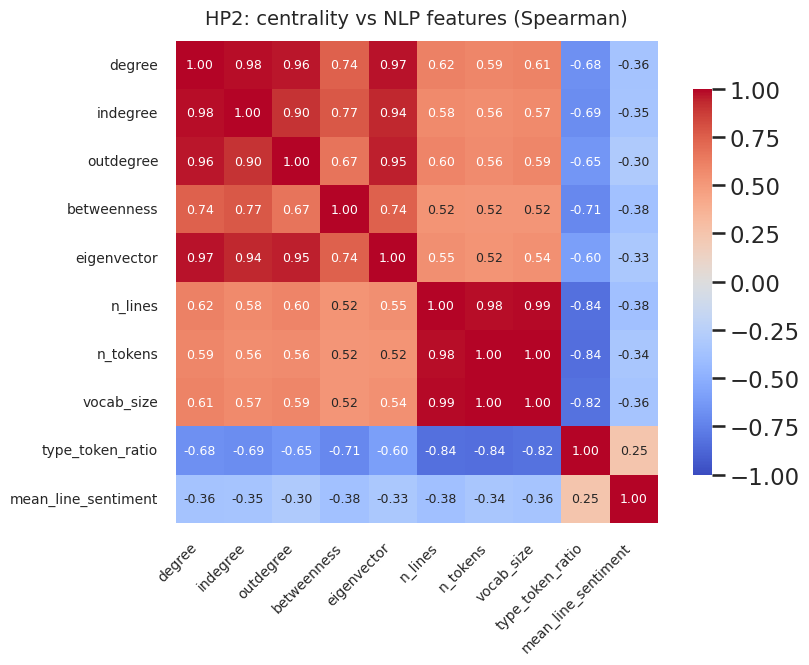

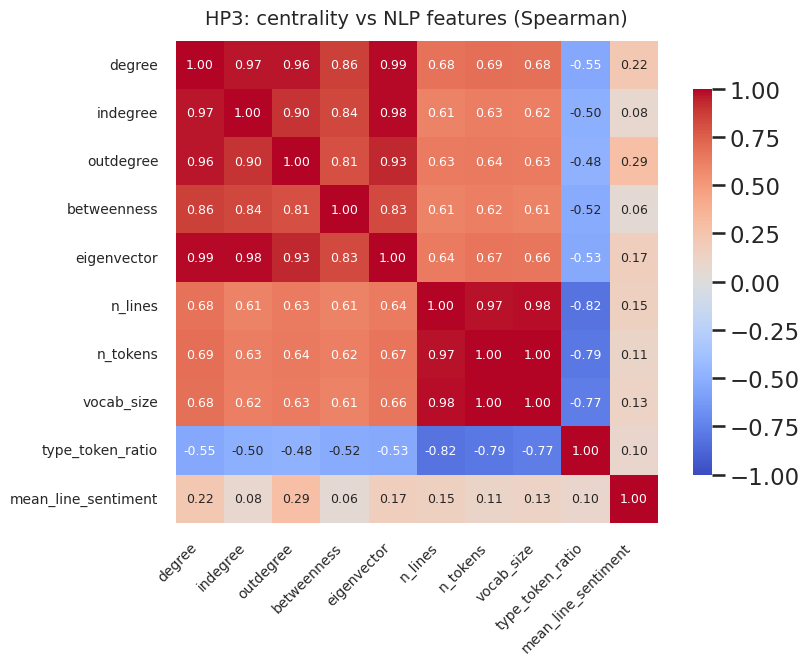

book
HP2    9
HP3    9
Name: count, dtype: int64


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,name_norm,book,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
2,HP2,14,Draco Malfoy,2,1,1,0.000000,0.000000,DRACO MALFOY,HP2,55,334,196,0.586826,-0.129114
3,HP2,19,Fred Weasley,17,8,9,0.012868,0.327897,FRED WEASLEY,HP2,7,47,36,0.765957,-0.034480
5,HP2,21,Ginny Weasley,4,3,1,0.003676,0.094378,GINNY WEASLEY,HP2,6,28,25,0.892857,-0.658407
6,HP2,25,Harry James Potter,24,17,7,0.586397,0.398053,HARRY JAMES POTTER,HP2,390,2078,585,0.281521,-0.138117
7,HP2,26,Hermione Granger,13,5,8,0.002451,0.309742,HERMIONE GRANGER,HP2,122,723,339,0.468880,-0.137269


In [ ]:
# centrality_cols / nlp_cols
centrality_cols = ["degree", "indegree", "outdegree", "betweenness", "eigenvector"]
nlp_cols = ["n_lines", "n_tokens", "vocab_size", "type_token_ratio", "mean_line_sentiment"]
cols_for_corr = centrality_cols + nlp_cols

corr_hp2 = df_hp2_merged[cols_for_corr].corr(method="spearman")
corr_hp3 = df_hp3_merged[cols_for_corr].corr(method="spearman")
centrality_cols = ["degree", "indegree", "outdegree", "betweenness", "eigenvector"]
nlp_cols = ["n_lines", "n_tokens", "vocab_size", "type_token_ratio", "mean_line_sentiment"]
cols_for_corr = centrality_cols + nlp_cols

corr_hp2 = df_hp2_merged[cols_for_corr].corr(method="spearman")
corr_hp3 = df_hp3_merged[cols_for_corr].corr(method="spearman")

print("HP2 Spearman correlations:")
display(corr_hp2)

print("HP3 Spearman correlations:")
display(corr_hp3)

def plot_corr_matrix(corr_mat, title):
    plt.figure(figsize=(9, 7))  # bigger figure
    sns.heatmap(
        corr_mat,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        vmin=-1,
        vmax=1,
        cbar_kws={"shrink": 0.8},
        annot_kws={"size": 9},   # smaller numbers in cells
    )
    plt.title(title, fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_corr_matrix(corr_hp2, "HP2: centrality vs NLP features (Spearman)")
plot_corr_matrix(corr_hp3, "HP3: centrality vs NLP features (Spearman)")

df_hp2_merged["book"] = "HP2"
df_hp3_merged["book"] = "HP3"

df_hp_merged = pd.concat([df_hp2_merged, df_hp3_merged], ignore_index=True)

min_lines = 5
df_hp_merged_filt = df_hp_merged[df_hp_merged["n_lines"] >= min_lines].copy()

print(df_hp_merged_filt["book"].value_counts())
df_hp_merged_filt.head()


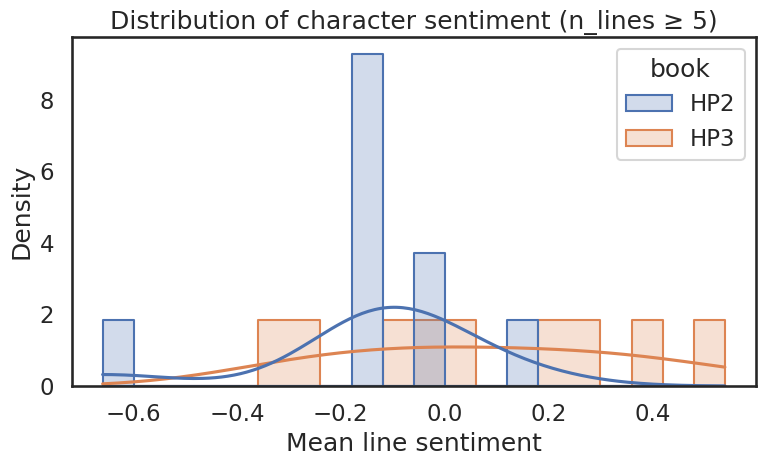

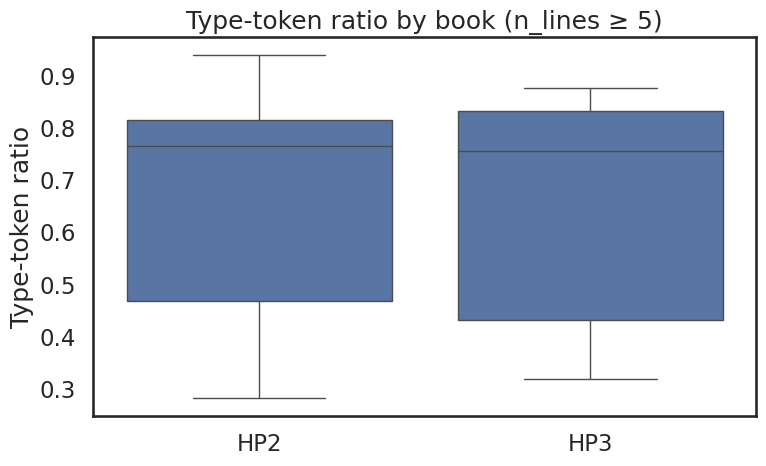

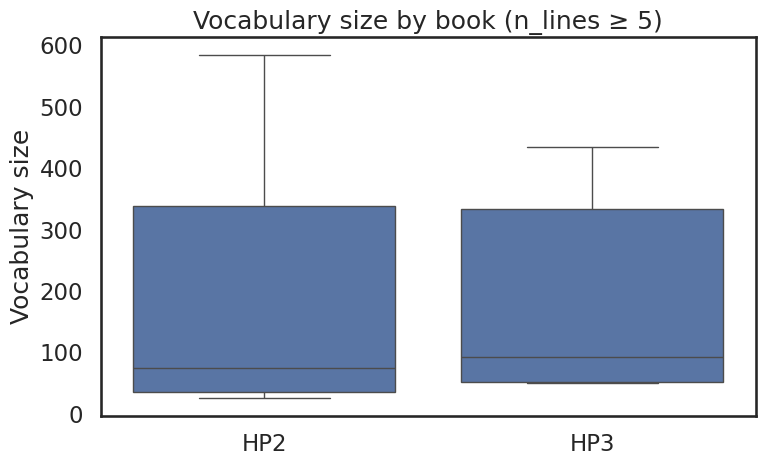

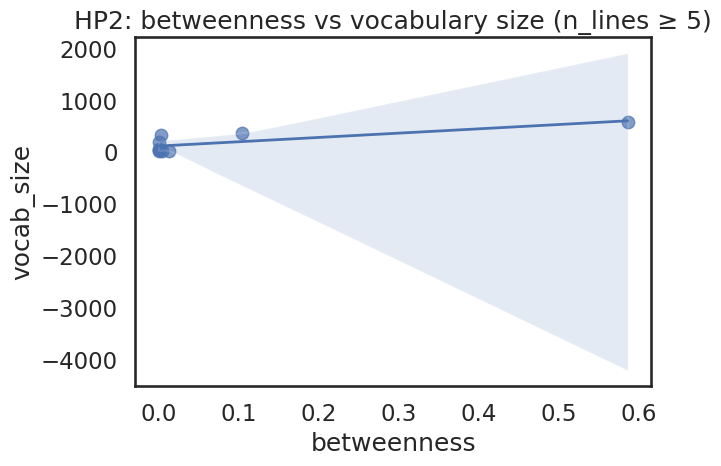

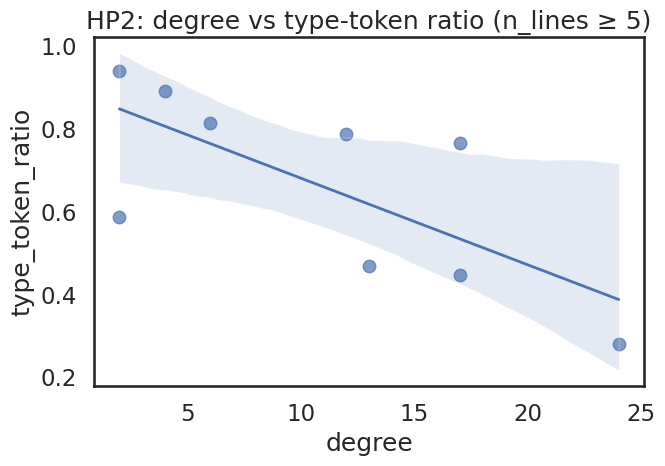

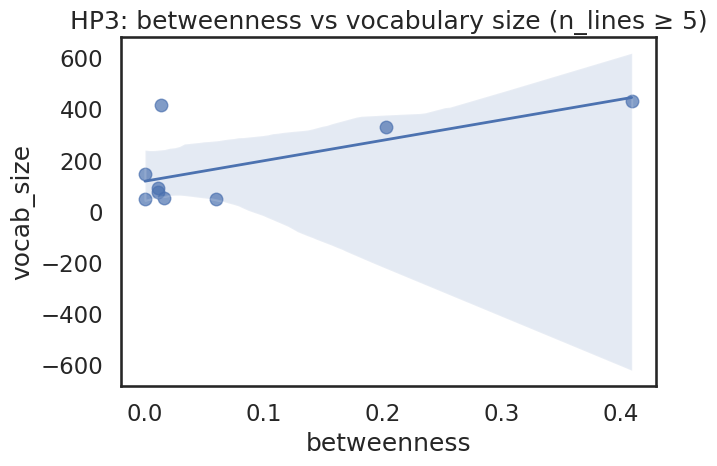

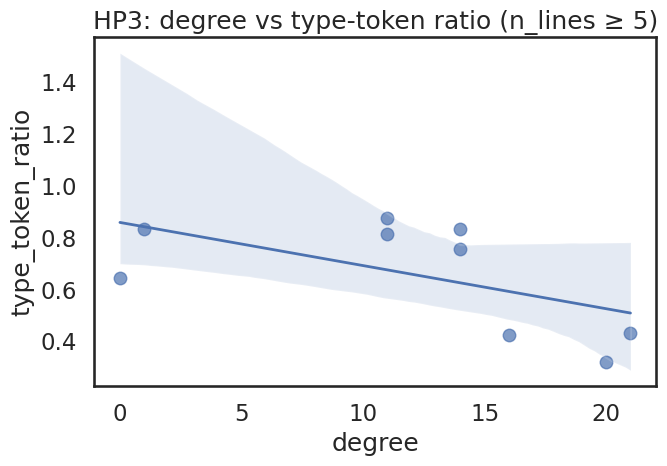

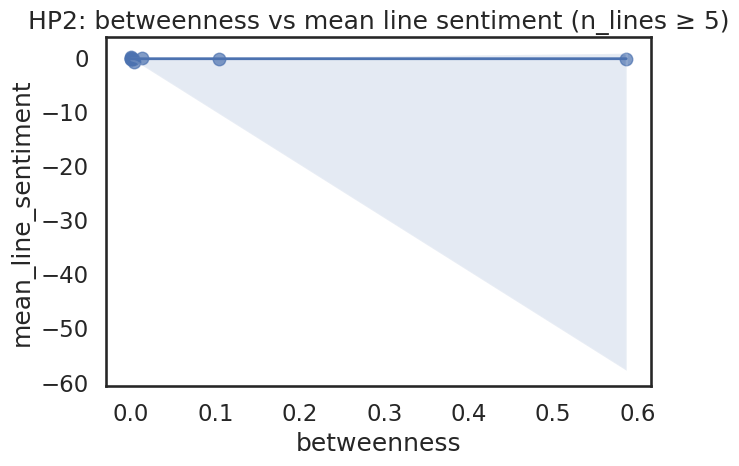

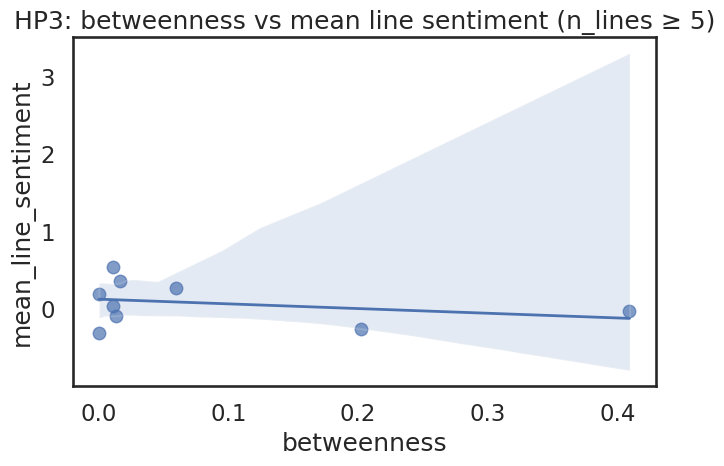

In [ ]:
# distribution of mean sentiment and lexical richness

plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_hp_merged_filt,
    x="mean_line_sentiment",
    hue="book",
    bins=20,
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
)
plt.xlabel("Mean line sentiment")
plt.ylabel("Density")
plt.title(f"Distribution of character sentiment (n_lines ≥ {min_lines})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_hp_merged_filt,
    x="book",
    y="type_token_ratio",
)
plt.xlabel("")
plt.ylabel("Type-token ratio")
plt.title(f"Type-token ratio by book (n_lines ≥ {min_lines})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_hp_merged_filt,
    x="book",
    y="vocab_size",
)
plt.xlabel("")
plt.ylabel("Vocabulary size")
plt.title(f"Vocabulary size by book (n_lines ≥ {min_lines})")
plt.tight_layout()
plt.show()

# === Cell: centrality vs lexical features (scatter + regression line) ===

def scatter_with_reg(df, x, y, title):
    plt.figure(figsize=(7, 5))
    sns.regplot(
        data=df,
        x=x,
        y=y,
        scatter_kws={"alpha": 0.7},
        line_kws={"linewidth": 2},
    )
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# HP2
scatter_with_reg(
    df_hp2_merged[df_hp2_merged["n_lines"] >= min_lines],
    x="betweenness",
    y="vocab_size",
    title=f"HP2: betweenness vs vocabulary size (n_lines ≥ {min_lines})",
)

scatter_with_reg(
    df_hp2_merged[df_hp2_merged["n_lines"] >= min_lines],
    x="degree",
    y="type_token_ratio",
    title=f"HP2: degree vs type-token ratio (n_lines ≥ {min_lines})",
)

# HP3
scatter_with_reg(
    df_hp3_merged[df_hp3_merged["n_lines"] >= min_lines],
    x="betweenness",
    y="vocab_size",
    title=f"HP3: betweenness vs vocabulary size (n_lines ≥ {min_lines})",
)

scatter_with_reg(
    df_hp3_merged[df_hp3_merged["n_lines"] >= min_lines],
    x="degree",
    y="type_token_ratio",
    title=f"HP3: degree vs type-token ratio (n_lines ≥ {min_lines})",
)

# === Cell: centrality vs sentiment (scatter + regression line) ===

scatter_with_reg(
    df_hp2_merged[df_hp2_merged["n_lines"] >= min_lines],
    x="betweenness",
    y="mean_line_sentiment",
    title=f"HP2: betweenness vs mean line sentiment (n_lines ≥ {min_lines})",
)

scatter_with_reg(
    df_hp3_merged[df_hp3_merged["n_lines"] >= min_lines],
    x="betweenness",
    y="mean_line_sentiment",
    title=f"HP3: betweenness vs mean line sentiment (n_lines ≥ {min_lines})",
)


#Section 4: Reproduce paper figures

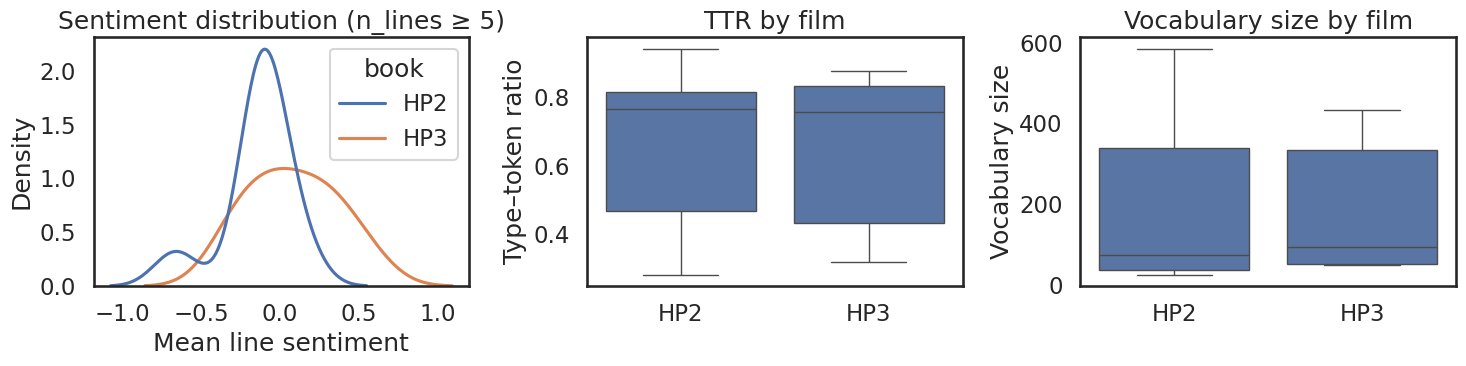

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.kdeplot(
    data=df_hp_merged_filt,
    x="mean_line_sentiment",
    hue="book",
    common_norm=False,
    ax=axes[0],
)
axes[0].set_xlabel("Mean line sentiment")
axes[0].set_ylabel("Density")
axes[0].set_title(f"Sentiment distribution (n_lines ≥ {min_lines})")

sns.boxplot(
    data=df_hp_merged_filt,
    x="book",
    y="type_token_ratio",
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("Type–token ratio")
axes[1].set_title("TTR by film")

sns.boxplot(
    data=df_hp_merged_filt,
    x="book",
    y="vocab_size",
    ax=axes[2],
)
axes[2].set_xlabel("")
axes[2].set_ylabel("Vocabulary size")
axes[2].set_title("Vocabulary size by film")

plt.tight_layout()
fig.savefig("hp2_hp3_nlp_distributions.png", dpi=300, bbox_inches="tight")
plt.show()


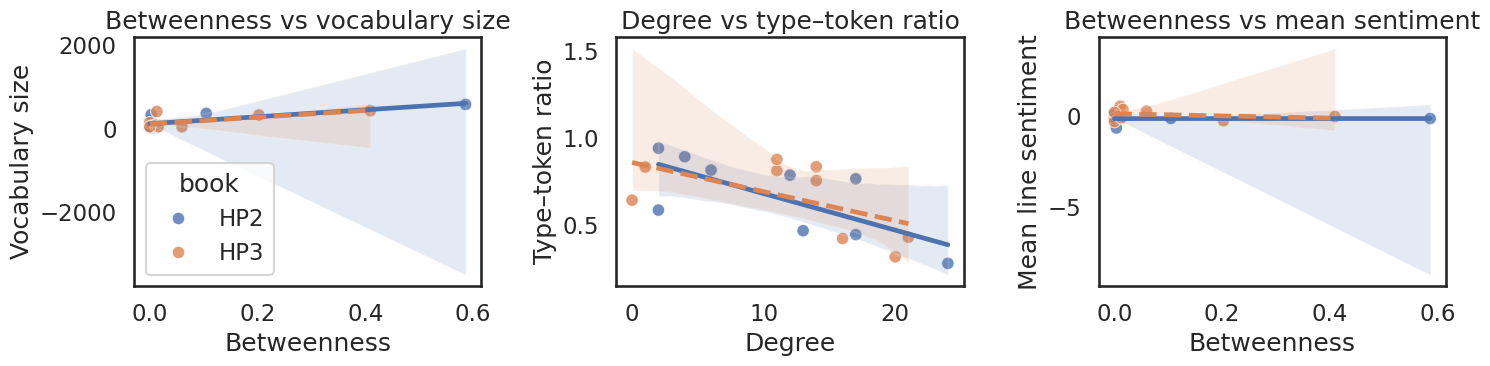

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df_plot = df_hp_merged_filt.copy()

# (a) betweenness vs vocab_size
sns.scatterplot(
    data=df_plot,
    x="betweenness",
    y="vocab_size",
    hue="book",
    ax=axes[0],
    alpha=0.8,
)
sns.regplot(
    data=df_plot[df_plot["book"] == "HP2"],
    x="betweenness",
    y="vocab_size",
    scatter=False,
    ax=axes[0],
)
sns.regplot(
    data=df_plot[df_plot["book"] == "HP3"],
    x="betweenness",
    y="vocab_size",
    scatter=False,
    ax=axes[0],
    line_kws={"linestyle": "--"},
)
axes[0].set_title("Betweenness vs vocabulary size")
axes[0].set_xlabel("Betweenness")
axes[0].set_ylabel("Vocabulary size")

# (b) degree vs TTR
sns.scatterplot(
    data=df_plot,
    x="degree",
    y="type_token_ratio",
    hue="book",
    ax=axes[1],
    alpha=0.8,
    legend=False,
)
sns.regplot(
    data=df_plot[df_plot["book"] == "HP2"],
    x="degree",
    y="type_token_ratio",
    scatter=False,
    ax=axes[1],
)
sns.regplot(
    data=df_plot[df_plot["book"] == "HP3"],
    x="degree",
    y="type_token_ratio",
    scatter=False,
    ax=axes[1],
    line_kws={"linestyle": "--"},
)
axes[1].set_title("Degree vs type–token ratio")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Type–token ratio")

# (c) betweenness vs mean sentiment
sns.scatterplot(
    data=df_plot,
    x="betweenness",
    y="mean_line_sentiment",
    hue="book",
    ax=axes[2],
    alpha=0.8,
    legend=False,
)
sns.regplot(
    data=df_plot[df_plot["book"] == "HP2"],
    x="betweenness",
    y="mean_line_sentiment",
    scatter=False,
    ax=axes[2],
)
sns.regplot(
    data=df_plot[df_plot["book"] == "HP3"],
    x="betweenness",
    y="mean_line_sentiment",
    scatter=False,
    ax=axes[2],
    line_kws={"linestyle": "--"},
)
axes[2].set_title("Betweenness vs mean sentiment")
axes[2].set_xlabel("Betweenness")
axes[2].set_ylabel("Mean line sentiment")

plt.tight_layout()
fig.savefig("hp2_hp3_centrality_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()


HP2 Spearman correlations:


,degree,indegree,outdegree,betweenness,eigenvector,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
degree,1.000000,0.976661,0.964017,0.742268,0.973884,0.615695,0.586804,0.608110,-0.677034,-0.364546
indegree,0.976661,1.000000,0.904100,0.774160,0.935984,0.578097,0.555787,0.573114,-0.687561,-0.353332
outdegree,0.964017,0.904100,1.000000,0.670148,0.949843,0.599193,0.564610,0.588654,-0.647990,-0.297183
betweenness,0.742268,0.774160,0.670148,1.000000,0.742377,0.523891,0.518570,0.518570,-0.714282,-0.376617
eigenvector,0.973884,0.935984,0.949843,0.742377,1.000000,0.552258,0.523909,0.543973,-0.600452,-0.326098
n_lines,0.615695,0.578097,0.599193,0.523891,0.552258,1.000000,0.981409,0.988067,-0.835594,-0.384059
n_tokens,0.586804,0.555787,0.564610,0.518570,0.523909,0.981409,1.000000,0.996046,-0.843604,-0.343284
vocab_size,0.608110,0.573114,0.588654,0.518570,0.543973,0.988067,0.996046,1.000000,-0.823540,-0.359087
type_token_ratio,-0.677034,-0.687561,-0.647990,-0.714282,-0.600452,-0.835594,-0.843604,-0.823540,1.000000,0.246801
mean_line_sentiment,-0.364546,-0.353332,-0.297183,-0.376617,-0.326098,-0.384059,-0.343284,-0.359087,0.246801,1.000000


HP3 Spearman correlations:


,degree,indegree,outdegree,betweenness,eigenvector,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
degree,1.000000,0.967736,0.964896,0.860497,0.986344,0.678728,0.692681,0.684957,-0.546697,0.224246
indegree,0.967736,1.000000,0.902516,0.840815,0.984732,0.605987,0.627264,0.623173,-0.498129,0.084887
outdegree,0.964896,0.902516,1.000000,0.810272,0.929895,0.633571,0.644761,0.634708,-0.477505,0.288352
betweenness,0.860497,0.840815,0.810272,1.000000,0.830318,0.607742,0.621658,0.607487,-0.524028,0.055354
eigenvector,0.986344,0.984732,0.929895,0.830318,1.000000,0.637217,0.669223,0.659252,-0.533738,0.170168
n_lines,0.678728,0.605987,0.633571,0.607742,0.637217,1.000000,0.971182,0.977075,-0.817756,0.152143
n_tokens,0.692681,0.627264,0.644761,0.621658,0.669223,0.971182,1.000000,0.996316,-0.789326,0.110375
vocab_size,0.684957,0.623173,0.634708,0.607487,0.659252,0.977075,0.996316,1.000000,-0.769711,0.126657
type_token_ratio,-0.546697,-0.498129,-0.477505,-0.524028,-0.533738,-0.817756,-0.789326,-0.769711,1.000000,0.095605
mean_line_sentiment,0.224246,0.084887,0.288352,0.055354,0.170168,0.152143,0.110375,0.126657,0.095605,1.000000


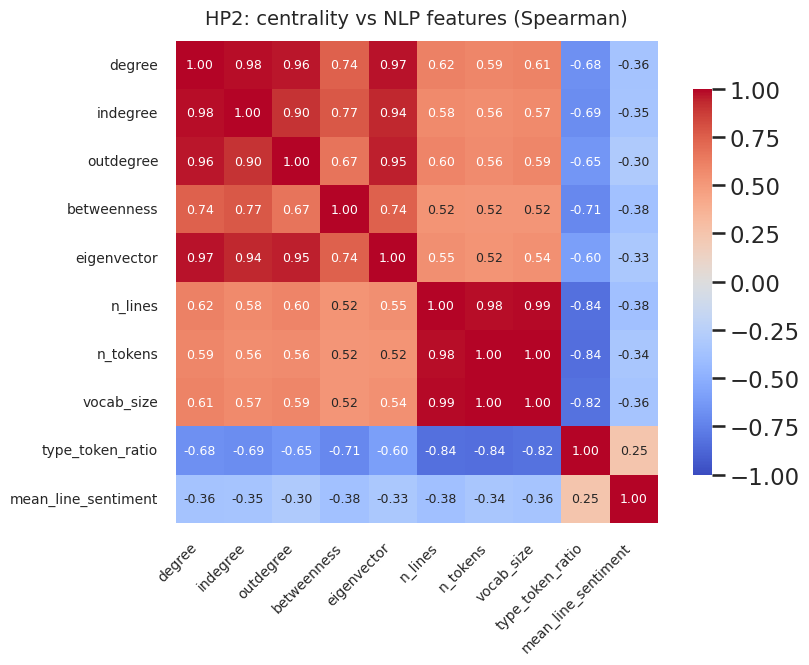

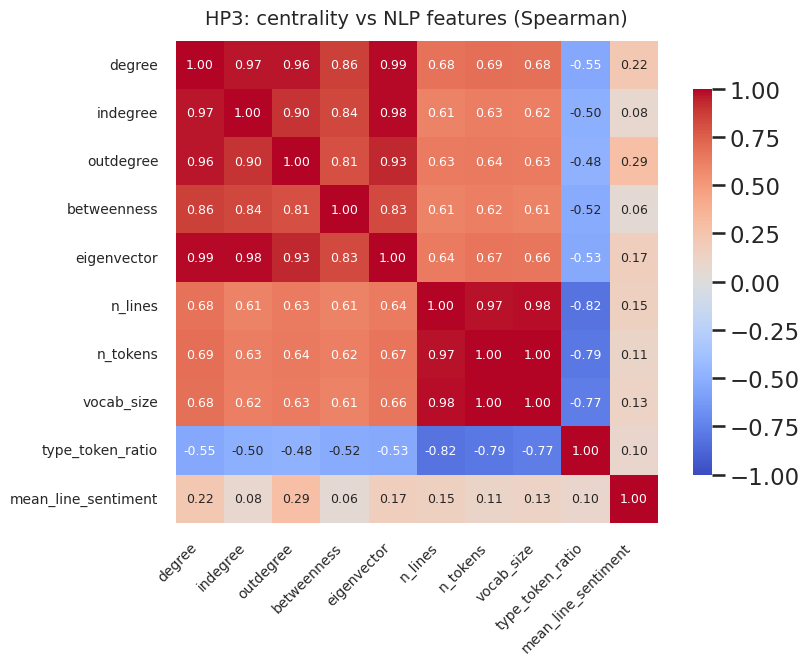

book
HP2    9
HP3    9
Name: count, dtype: int64


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,name_norm,book,n_lines,n_tokens,vocab_size,type_token_ratio,mean_line_sentiment
2,HP2,14,Draco Malfoy,2,1,1,0.000000,0.000000,DRACO MALFOY,HP2,55,334,196,0.586826,-0.129114
3,HP2,19,Fred Weasley,17,8,9,0.012868,0.327897,FRED WEASLEY,HP2,7,47,36,0.765957,-0.034480
5,HP2,21,Ginny Weasley,4,3,1,0.003676,0.094378,GINNY WEASLEY,HP2,6,28,25,0.892857,-0.658407
6,HP2,25,Harry James Potter,24,17,7,0.586397,0.398053,HARRY JAMES POTTER,HP2,390,2078,585,0.281521,-0.138117
7,HP2,26,Hermione Granger,13,5,8,0.002451,0.309742,HERMIONE GRANGER,HP2,122,723,339,0.468880,-0.137269


In [ ]:
# centrality_cols / nlp_cols
centrality_cols = ["degree", "indegree", "outdegree", "betweenness", "eigenvector"]
nlp_cols = ["n_lines", "n_tokens", "vocab_size", "type_token_ratio", "mean_line_sentiment"]
cols_for_corr = centrality_cols + nlp_cols

corr_hp2 = df_hp2_merged[cols_for_corr].corr(method="spearman")
corr_hp3 = df_hp3_merged[cols_for_corr].corr(method="spearman")
centrality_cols = ["degree", "indegree", "outdegree", "betweenness", "eigenvector"]
nlp_cols = ["n_lines", "n_tokens", "vocab_size", "type_token_ratio", "mean_line_sentiment"]
cols_for_corr = centrality_cols + nlp_cols

corr_hp2 = df_hp2_merged[cols_for_corr].corr(method="spearman")
corr_hp3 = df_hp3_merged[cols_for_corr].corr(method="spearman")

print("HP2 Spearman correlations:")
display(corr_hp2)

print("HP3 Spearman correlations:")
display(corr_hp3)

def plot_corr_matrix(corr_mat, title):
    plt.figure(figsize=(9, 7))  # bigger figure
    sns.heatmap(
        corr_mat,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        vmin=-1,
        vmax=1,
        cbar_kws={"shrink": 0.8},
        annot_kws={"size": 9},   # smaller numbers in cells
    )
    plt.title(title, fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_corr_matrix(corr_hp2, "HP2: centrality vs NLP features (Spearman)")
plot_corr_matrix(corr_hp3, "HP3: centrality vs NLP features (Spearman)")

df_hp2_merged["book"] = "HP2"
df_hp3_merged["book"] = "HP3"

df_hp_merged = pd.concat([df_hp2_merged, df_hp3_merged], ignore_index=True)

min_lines = 5
df_hp_merged_filt = df_hp_merged[df_hp_merged["n_lines"] >= min_lines].copy()

print(df_hp_merged_filt["book"].value_counts())
df_hp_merged_filt.head()


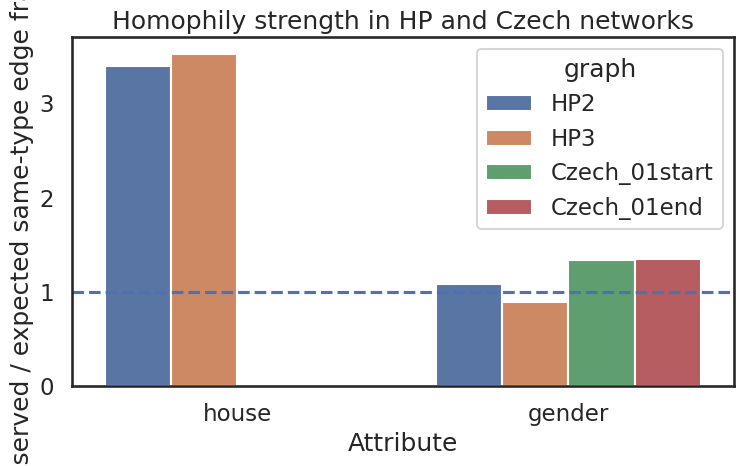

In [ ]:
# Plot homophily strength (observed / expected)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_mixing_summary,
    x="attr",
    y="ratio_obs_over_expected",
    hue="graph",
)
plt.axhline(1.0, linestyle="--")
plt.ylabel("Observed / expected same-type edge fraction")
plt.xlabel("Attribute")
plt.title("Homophily strength in HP and Czech networks")
plt.tight_layout()
plt.show()
